### MPA_RF

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Saving into Log

In [2]:
import logging

# Setup basic configuration for logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("RF_optimization_MIT_new.log"),  # Log to this file
                        logging.StreamHandler()  # Log to standard output
                    ])

### Determining necessary parameters

In [3]:
import numpy as np

# Example usage with the correct bounds for SVM:
search_agents_no = 30  # number of search agents
dim = 2  # number of dimensions / hyperparameters
Max_iter = 20  # Maximum number of iterations

# Bounds for 'max_depth' (discrete, integer)
max_depth_lb = 10
max_depth_ub = 105  # Assuming inclusive upper bound

# Bounds for 'n_estimators' (discrete, integer)
n_estimators_lb = 10
n_estimators_ub = 2000  # Assuming inclusive upper bound

# Create arrays of lower bounds (lb) and upper bounds (ub)
lb = np.array([n_estimators_lb, max_depth_lb])
ub = np.array([n_estimators_ub, max_depth_ub])


### Loading Training Dataset

In [4]:
import cudf
import pandas as pd
from cuml.ensemble import RandomForestClassifier as cumlRF
from cuml.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from cuml.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
train_data = cudf.read_csv('/home/jupyter-yangiev/MPA_int_ML/mitbih_train_new.csv')

columns = train_data.columns.tolist()
features = [col for col in columns if col != '187']
labels = '187'

# Split features and labels
X = train_data[features]
y = train_data[labels]

# Convert feature data to float32
X = X.astype('float32')

# Assuming your target data is for classification and should be integers
y = y.astype('int32')

# Convert to pandas DataFrame for resampling
X_pd = X.to_pandas()
y_pd = y.to_pandas()

# Apply Random Over Sampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_pd, y_pd)

# Convert resampled data back to cuDF for further processing
X_resampled = cudf.DataFrame.from_pandas(X_resampled)
y_resampled = cudf.Series(y_resampled)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

2024-04-16 05:42:28,059 - INFO - init


### Levy, Initialization, Fitness and Confusion Matrix Plot Functions

In [5]:
import math

# Levy function
def levy(search_agents_no, dim, beta=3/2):
    sigma = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2)) / \
            (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2)) ** (1 / beta)
    u = np.random.randn(search_agents_no, dim) * sigma
    v = np.random.randn(search_agents_no, dim)
    step = u / (np.abs(v) ** (1 / beta))
    L = 0.05 * step  # Scale factor can be adjusted as needed
    return L

# Prey initialization function 
def initialization(search_agents_no, dim, ub, lb):
    if np.isscalar(lb) and np.isscalar(ub):
        # If the boundaries are both single numbers, apply them to all dimensions
        positions = np.random.rand(search_agents_no, dim) * (ub - lb) + lb
    else:
        # If the boundaries are arrays with different values for each dimension
        positions = np.zeros((search_agents_no, dim))
        for i in range(dim):
            ub_i = ub[i]
            lb_i = lb[i]
            positions[:, i] = np.random.rand(search_agents_no) * (ub_i - lb_i) + lb_i
    return positions

# Objective fitness function 
def rf_accuracy_fitness(X_params, X_train, y_train, X_val, y_val):
    print("X_params shape:", X_params.shape)
    # Parameters from optimization algorithm
    n_estimators, max_depth = int(round(X_params[0][0])), int(round(X_params[0][1]))
    print("n_estimators:", n_estimators, "max_depth:", max_depth)
 
    model = cumlRF(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_streams=1)

    # Fit model
    model.fit(X_train, y_train)

    # Predict on validation set
    preds = model.predict(X_val)
    # Ensure predictions are integers
    preds = preds.astype('int32')
    
    # Compute overall accuracy
    overall_fitness = accuracy_score(y_val, preds)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_val, preds)
    
    # Calculate per-class accuracy
    if hasattr(conf_matrix, 'get'):
        conf_matrix = conf_matrix.get()  # Convert from CuPy to NumPy if necessary
    true_positives = np.diag(conf_matrix)
    total_predictions = np.sum(conf_matrix, axis=1)
    per_class_accuracy = true_positives / total_predictions
    fitness = np.nanmean(per_class_accuracy)  # Use nanmean to ignore NaN results from classes with zero samples

    # Return mean per-class accuracies along with the confusion matrix
    return fitness, conf_matrix



# Confusion Matrix Plot function
def plot_confusion_matrix(conf_matrix, individual_index):
    if hasattr(conf_matrix, 'get'):
        conf_matrix_np = conf_matrix.get()  # Convert CuPy array to NumPy array
    else:
        conf_matrix_np = np.array(conf_matrix)  # Ensure it is a NumPy array

    # Calculate the percentage of each element relative to the row sum
    row_sums = conf_matrix_np.sum(axis=1)[:, np.newaxis]  # Reshape for broadcasting
    conf_matrix_percent = 100 * conf_matrix_np / row_sums
    conf_matrix_percent = np.nan_to_num(conf_matrix_percent)  # Replace nan with 0, can occur if row sum is 0

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", cbar=True, ax=ax)

    # Adjust the subplot params for a nicer fit
    plt.subplots_adjust(left=0.2, right=0.8, top=0.95, bottom=0.15)

    plt.title(f'Confusion Matrix for Individual {individual_index + 1}')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')

    # Set the custom tick labels for each axis
    ax.set_xticklabels(['N', 'S', 'V', 'F', 'Q'], rotation=0)
    ax.set_yticklabels(['N', 'S', 'V', 'F', 'Q'])

    plt.show()


def get_model_from_params(params):
    n_estimators, max_depth = round(params[0]), round(params[1])
    model = cumlRF(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42, n_streams=1)
    return model


### Define MPA function

In [6]:
import pickle

def MPA(search_agents_no, Max_iter, lb, ub, dim, X_train, y_train, X_val, y_val, rf_accuracy_fitness, fitness_threshold=0.95):
   
    Top_predator_pos = np.zeros(dim)
    Top_predator_fit = -np.inf  # Start with the lowest possible value
    best_model = None  # Variable to store the best model
    stepsize = np.zeros((search_agents_no, dim))
    fitness = np.full(search_agents_no, -np.inf)
     
    Prey = initialization(search_agents_no, dim, ub, lb)
    model_path = 'best_model_mpa_RF_mit.pkl'  # Define the path where the model will be saved
    Xmin = np.tile(lb, (search_agents_no, 1))
    Xmax = np.tile(ub, (search_agents_no, 1))

    best_fitness_values = []  # Keep track of the best fitness value at each iteration
    average_fitness_values = []  # Keep track of the average fitness value
    
    Iter = 0
    FADs = 0.2
    P = 0.5

    for Iter in range(Max_iter):
        # Detecting Top predator
        for i in range(search_agents_no):
            Flag4ub = Prey[i, :] > ub
            Flag4lb = Prey[i, :] < lb
            Prey[i, :] = Prey[i, :] * (~(Flag4ub | Flag4lb)) + ub * Flag4ub + lb * Flag4lb
            logging.info(f"Calculating fitness for individual {i+1}/{search_agents_no}")
            fitness[i], conf_matrix = rf_accuracy_fitness(Prey[[i], :], X_train, y_train, X_val, y_val)
           
            logging.info(f"Fitness for individual {i+1}: {fitness[i]}")
            # Plot the confusion matrix for the current individual
            plot_confusion_matrix(conf_matrix, i)
            
            if fitness[i] > Top_predator_fit:
                Top_predator_fit = fitness[i]
                Top_predator_pos = Prey[i, :].copy()
                best_model = get_model_from_params(Top_predator_pos)  # Assuming you have a function to create a model from params
                
        # Marine memory saving
        if Iter == 0:
            fit_old = fitness.copy()
            Prey_old = Prey.copy()
        
        # For maximization: Check if the current fitness is greater than the old fitness
        Inx = fitness > fit_old
        Indx = np.tile(Inx[:, None], (1, dim))
        
        # Update positions: Use the newer positions if the current fitness is better; otherwise, revert to old positions
        Prey = Indx * Prey + (~Indx) * Prey_old
        
        # Update fitness: Keep the higher current fitness values; otherwise, revert to old fitness values
        fitness = np.where(Inx, fitness, fit_old)
        
        fit_old = fitness.copy()  # Prepare for the next iteration
        Prey_old = Prey.copy()

        # --------------------////------------------
        Elite = np.tile(Top_predator_pos, (search_agents_no, 1))  # Construct Elite Matrix
        CF = (1 - Iter / Max_iter) ** (2 * Iter / Max_iter)

        RL = 0.05 * levy(search_agents_no, dim, 1.5)    # Levy random number vector
        RB = np.random.randn(search_agents_no, dim)     # Brownian random number vector

        for i in range(search_agents_no):
            for j in range(dim):
                R = np.random.rand()
                # Phase 1
                if Iter < Max_iter / 3:
                    stepsize[i, j] = RB[i, j] * (Elite[i, j] - RB[i, j] * Prey[i, j])
                    Prey[i, j] = Prey[i, j] + P * R * stepsize[i, j]
                # Phase 2
                elif Max_iter / 3 < Iter < 2 * Max_iter / 3:
                    if i > search_agents_no / 2:
                        stepsize[i, j] = RB[i, j] * (RB[i, j] * Elite[i, j] - Prey[i, j])
                        Prey[i, j] = Elite[i, j] + P * CF * stepsize[i, j]
                    else:
                        stepsize[i, j] = RL[i, j] * (Elite[i, j] - RL[i, j] * Prey[i, j])
                        Prey[i, j] = Prey[i, j] + P * R * stepsize[i, j]
                # Phase 3
                else:
                    stepsize[i, j] = RL[i, j] * (RL[i, j] * Elite[i, j] - Prey[i, j])
                    Prey[i, j] = Elite[i, j] + P * CF * stepsize[i, j]
                # ------------------ Detecting top predator ------------------  
        for i in range(search_agents_no):
            # Enforce boundary conditions
            Flag4ub = Prey[i, :] > ub
            Flag4lb = Prey[i, :] < lb
            Prey[i, :] = (Prey[i, :] * (~(Flag4ub | Flag4lb))) + ub * Flag4ub + lb * Flag4lb
            logging.info(f"Calculating fitness for individual after 3 Phases {i+1}/{search_agents_no}")
            # Evaluate fitness
            fitness[i], conf_matrix = rf_accuracy_fitness(Prey[[i], :], X_train, y_train, X_val, y_val)
           
            logging.info(f"Fitness for individual {i+1}: {fitness[i]}")
            # Plot the confusion matrix for the current individual
            plot_confusion_matrix(conf_matrix, i)
            
            # Update top predator if current solution is better (for maximization)
            if fitness[i] > Top_predator_fit:
                Top_predator_fit = fitness[i]
                Top_predator_pos = Prey[i, :].copy()
                best_model = get_model_from_params(Top_predator_pos)  # Assuming you have a function to create a model from params
                
        # Marine memory saving  --------///-----------
        if Iter == 0:
            fit_old = fitness.copy()
            Prey_old = Prey.copy()
        
        Inx = fitness > fit_old  # For maximization: keep if current fitness is better
        Indx = np.tile(Inx[:, None], (1, dim))
        Prey = Indx * Prey + (~Indx) * Prey_old  # Update positions based on better fitness
        fitness = np.where(Inx, fitness, fit_old)  # Update fitness values accordingly
        
        fit_old = fitness.copy()  # Update old fitness for the next iteration
        Prey_old = Prey.copy()  # Update old positions for the next iteration
        
        
        # Eddy formation and FADs’ effect
        if np.random.rand() < FADs:
            U = np.random.rand(search_agents_no, dim) < FADs
            Prey = Prey + CF * ((Xmin + np.random.rand(search_agents_no, dim) * (Xmax - Xmin)) * U)
        else:
            r = np.random.rand()
            Rs = Prey.shape[0]
            stepsize = (FADs * (1 - r) + r) * (Prey[np.random.permutation(Rs), :] - Prey[np.random.permutation(Rs), :])
            Prey = Prey + stepsize

        current_best_fitness = Top_predator_fit
        best_fitness_values.append(current_best_fitness)
        
        # Calculate average fitness of the population
        current_avg_fitness = np.mean(fitness)
        average_fitness_values.append(current_avg_fitness)
        
        # Log the metrics
        logging.info(f"Iteration: {Iter+1}/{Max_iter}, Best Fitness: {current_best_fitness}, Average Fitness: {current_avg_fitness}")
        
        if Top_predator_fit >= fitness_threshold:
            logging.info(f"Fitness threshold reached: {Top_predator_fit} at iteration {Iter+1}. Terminating...")
            with open(model_path, 'wb') as f:
                pickle.dump(best_model, f)  # Save the best model
            logging.info(f"Model saved to {model_path} with fitness {Top_predator_fit} at iteration {Iter+1}")
            break  # Exit the loop if fitness threshold is reached
        
        # Update iteration counter and convergence curve
        Iter += 1

    return Top_predator_pos, Top_predator_fit


### Call MPA

2024-04-16 05:42:30,687 - INFO - Calculating fitness for individual 1/30


X_params shape: (1, 2)
n_estimators: 827 max_depth: 32


2024-04-16 05:43:06,292 - INFO - Fitness for individual 1: 0.9986012977142046


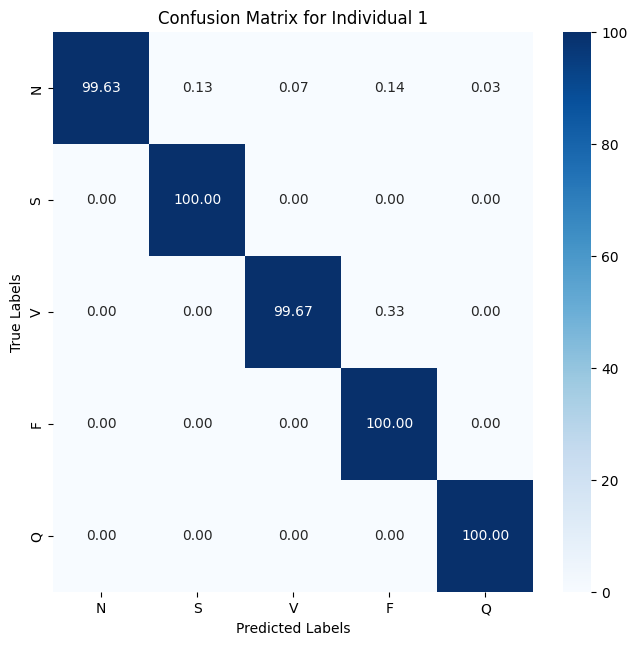

2024-04-16 05:43:06,689 - INFO - Calculating fitness for individual 2/30


X_params shape: (1, 2)
n_estimators: 1126 max_depth: 89


2024-04-16 05:44:09,988 - INFO - Fitness for individual 2: 0.999529802240354


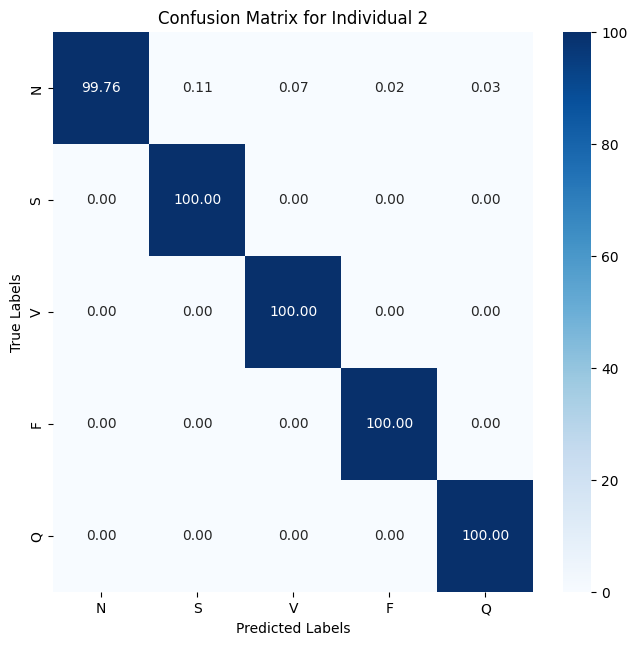

2024-04-16 05:44:10,373 - INFO - Calculating fitness for individual 3/30


X_params shape: (1, 2)
n_estimators: 406 max_depth: 15


2024-04-16 05:44:23,032 - INFO - Fitness for individual 3: 0.9960002892582335


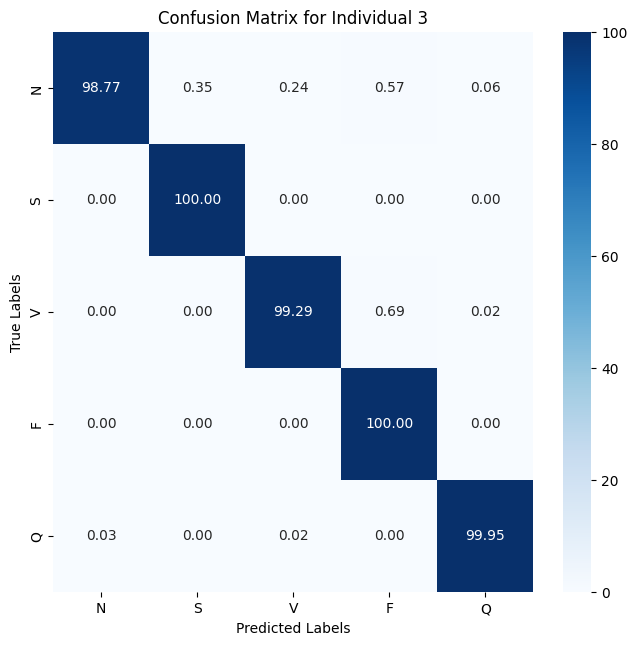

2024-04-16 05:44:23,413 - INFO - Calculating fitness for individual 4/30


X_params shape: (1, 2)
n_estimators: 1571 max_depth: 73


2024-04-16 05:45:51,352 - INFO - Fitness for individual 4: 0.9995021435486102


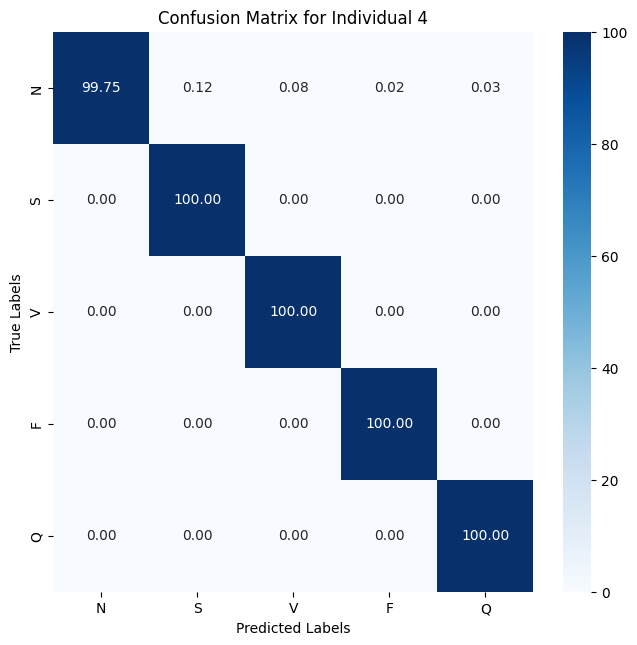

2024-04-16 05:45:51,782 - INFO - Calculating fitness for individual 5/30


X_params shape: (1, 2)
n_estimators: 1007 max_depth: 64


2024-04-16 05:46:47,337 - INFO - Fitness for individual 5: 0.999529802240354


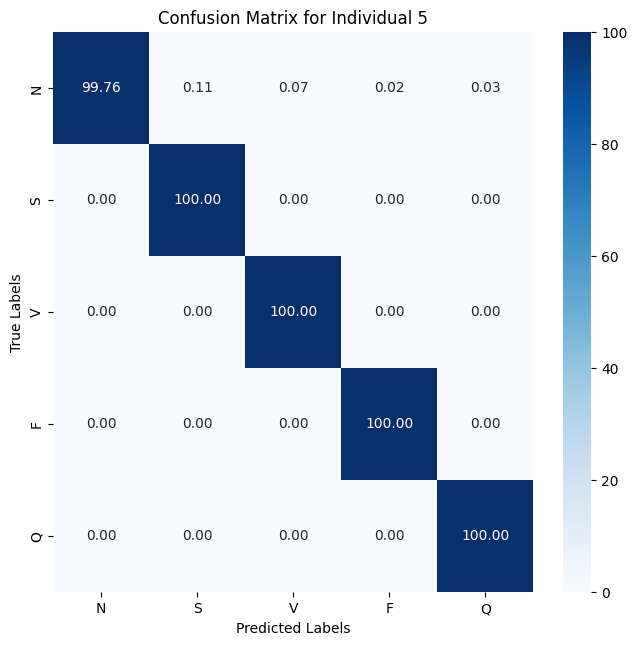

2024-04-16 05:46:47,771 - INFO - Calculating fitness for individual 6/30


X_params shape: (1, 2)
n_estimators: 1458 max_depth: 87


2024-04-16 05:48:08,906 - INFO - Fitness for individual 6: 0.9995021435486102


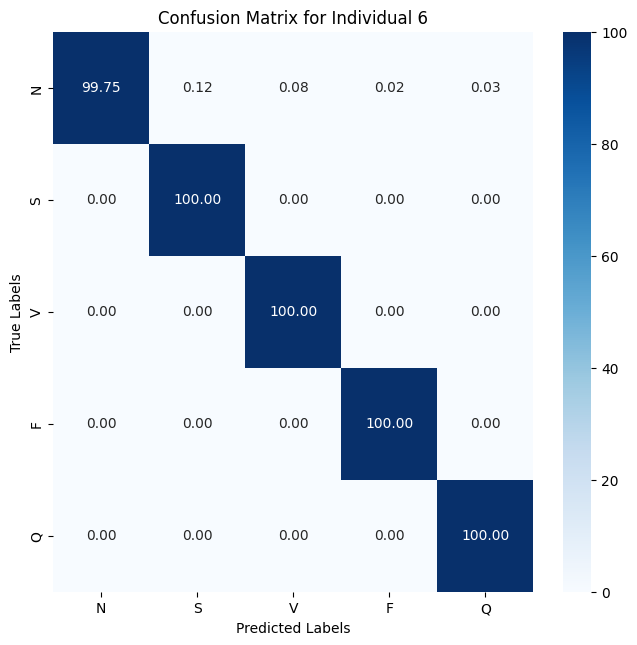

2024-04-16 05:48:09,399 - INFO - Calculating fitness for individual 7/30


X_params shape: (1, 2)
n_estimators: 301 max_depth: 93


2024-04-16 05:48:26,544 - INFO - Fitness for individual 7: 0.9994883142027382


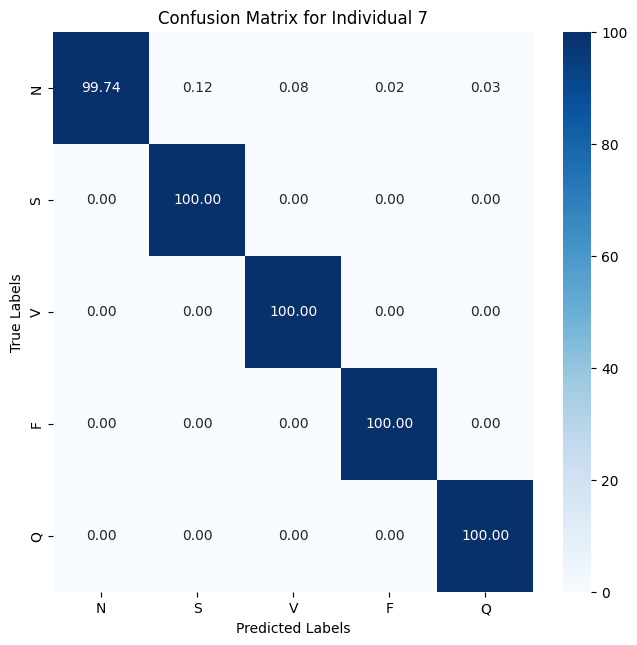

2024-04-16 05:48:26,968 - INFO - Calculating fitness for individual 8/30


X_params shape: (1, 2)
n_estimators: 359 max_depth: 74


2024-04-16 05:48:47,120 - INFO - Fitness for individual 8: 0.9994883142027382


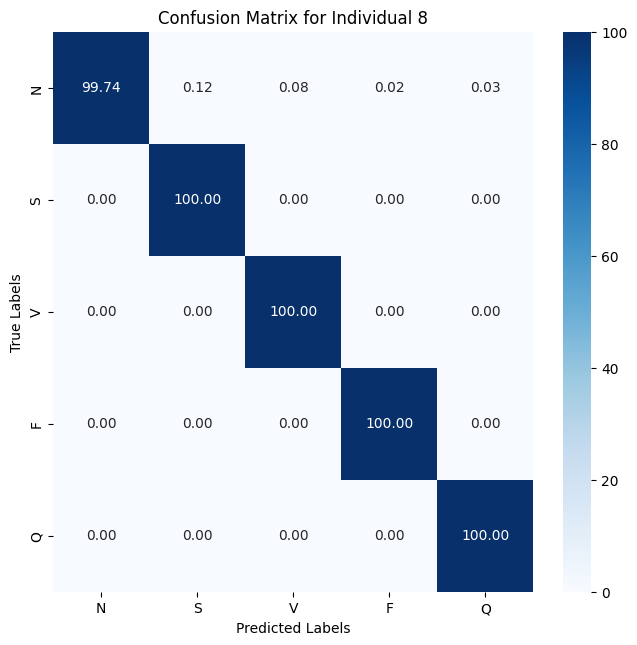

2024-04-16 05:48:47,491 - INFO - Calculating fitness for individual 9/30


X_params shape: (1, 2)
n_estimators: 626 max_depth: 30


2024-04-16 05:49:12,955 - INFO - Fitness for individual 9: 0.9984627568062004


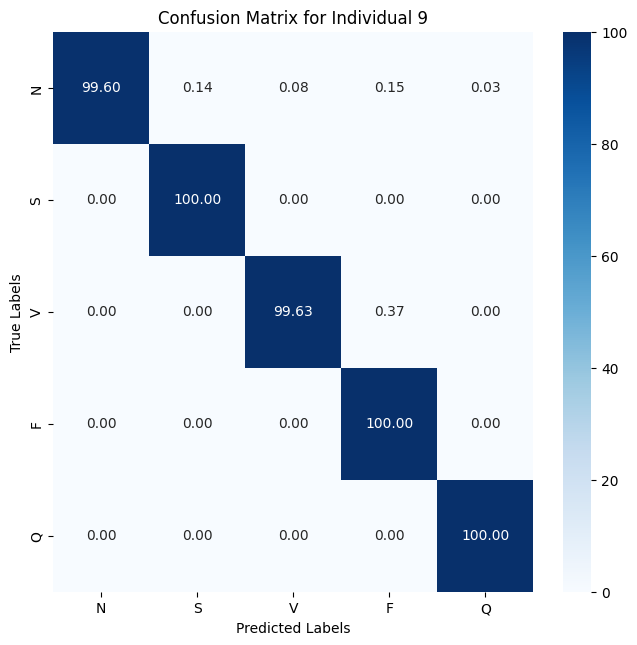

2024-04-16 05:49:13,328 - INFO - Calculating fitness for individual 10/30


X_params shape: (1, 2)
n_estimators: 1339 max_depth: 84


2024-04-16 05:50:27,680 - INFO - Fitness for individual 10: 0.999529802240354


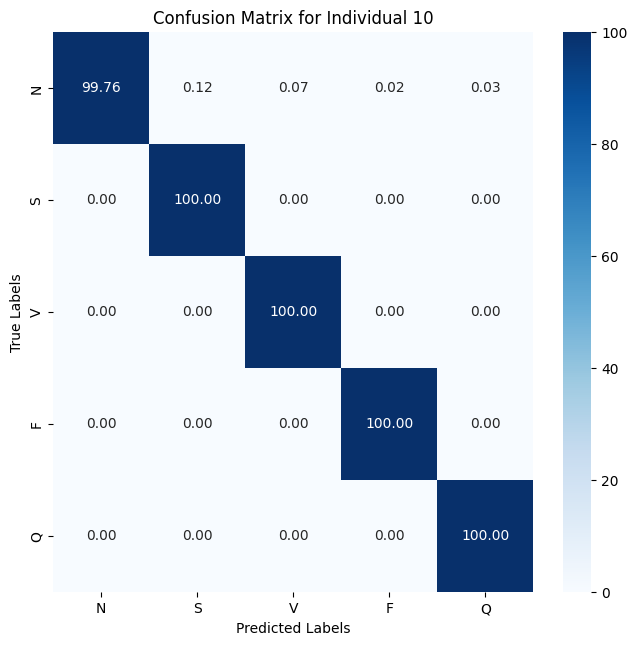

2024-04-16 05:50:28,263 - INFO - Calculating fitness for individual 11/30


X_params shape: (1, 2)
n_estimators: 1317 max_depth: 19


2024-04-16 05:51:10,449 - INFO - Fitness for individual 11: 0.9973553368562118


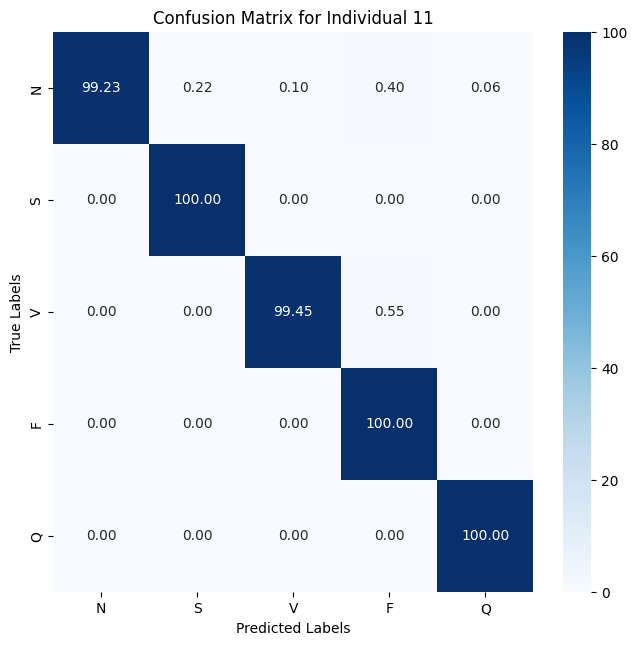

2024-04-16 05:51:10,823 - INFO - Calculating fitness for individual 12/30


X_params shape: (1, 2)
n_estimators: 1587 max_depth: 86


2024-04-16 05:52:38,831 - INFO - Fitness for individual 12: 0.9995021435486102


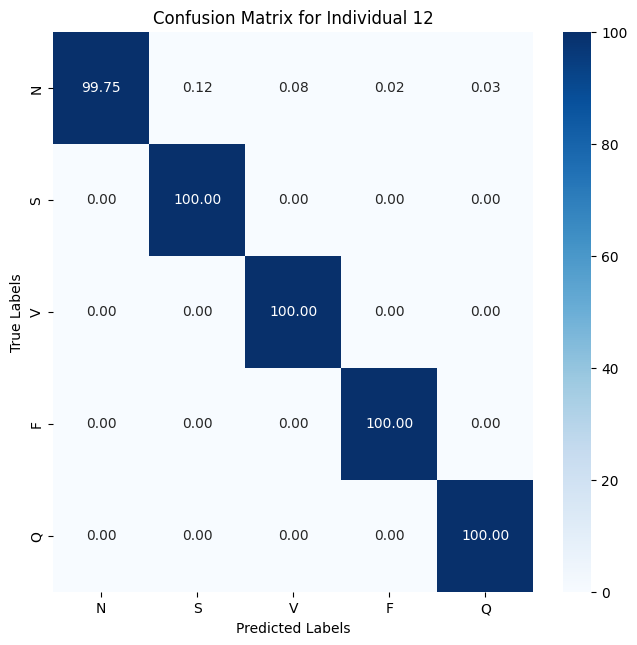

2024-04-16 05:52:39,285 - INFO - Calculating fitness for individual 13/30


X_params shape: (1, 2)
n_estimators: 667 max_depth: 68


2024-04-16 05:53:16,353 - INFO - Fitness for individual 13: 0.9995021435486102


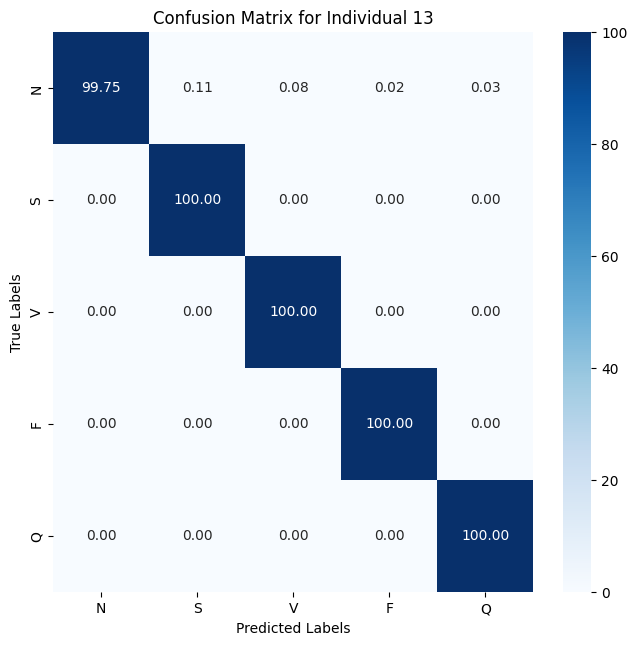

2024-04-16 05:53:16,724 - INFO - Calculating fitness for individual 14/30


X_params shape: (1, 2)
n_estimators: 1922 max_depth: 52


2024-04-16 05:54:54,315 - INFO - Fitness for individual 14: 0.9994467436820276


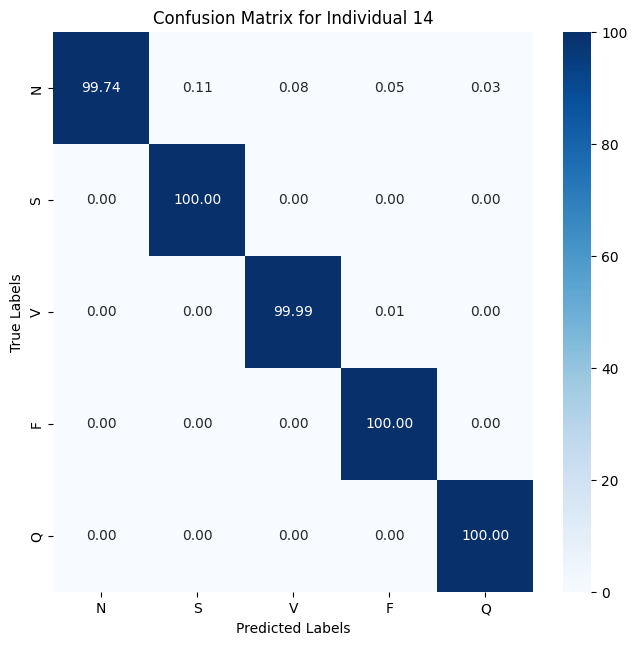

2024-04-16 05:54:54,680 - INFO - Calculating fitness for individual 15/30


X_params shape: (1, 2)
n_estimators: 165 max_depth: 87


2024-04-16 05:55:04,223 - INFO - Fitness for individual 15: 0.9994744848568663


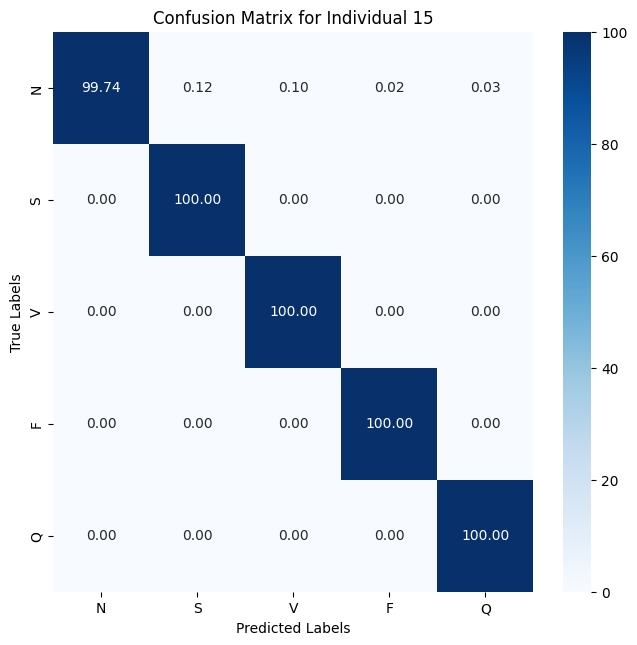

2024-04-16 05:55:04,597 - INFO - Calculating fitness for individual 16/30


X_params shape: (1, 2)
n_estimators: 527 max_depth: 68


2024-04-16 05:55:34,030 - INFO - Fitness for individual 16: 0.9995574609320979


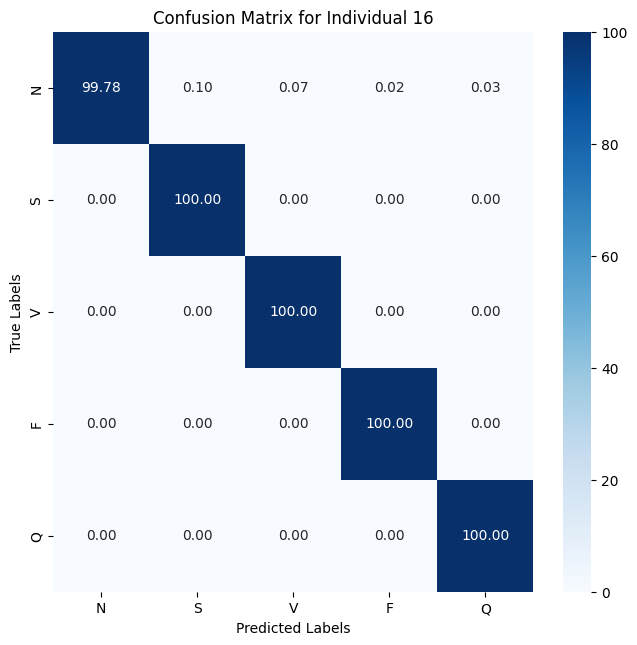

2024-04-16 05:55:34,408 - INFO - Calculating fitness for individual 17/30


X_params shape: (1, 2)
n_estimators: 1694 max_depth: 49


2024-04-16 05:56:58,587 - INFO - Fitness for individual 17: 0.9993082027740237


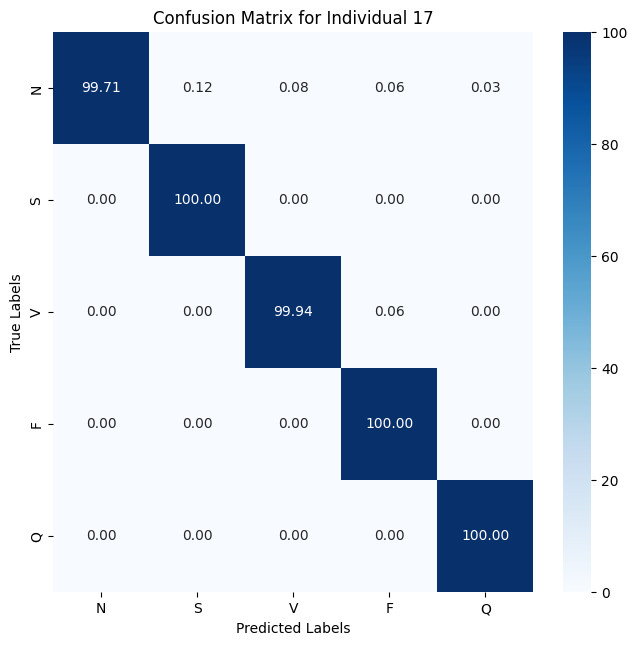

2024-04-16 05:56:59,012 - INFO - Calculating fitness for individual 18/30


X_params shape: (1, 2)
n_estimators: 1424 max_depth: 66


2024-04-16 05:58:16,795 - INFO - Fitness for individual 18: 0.999515972894482


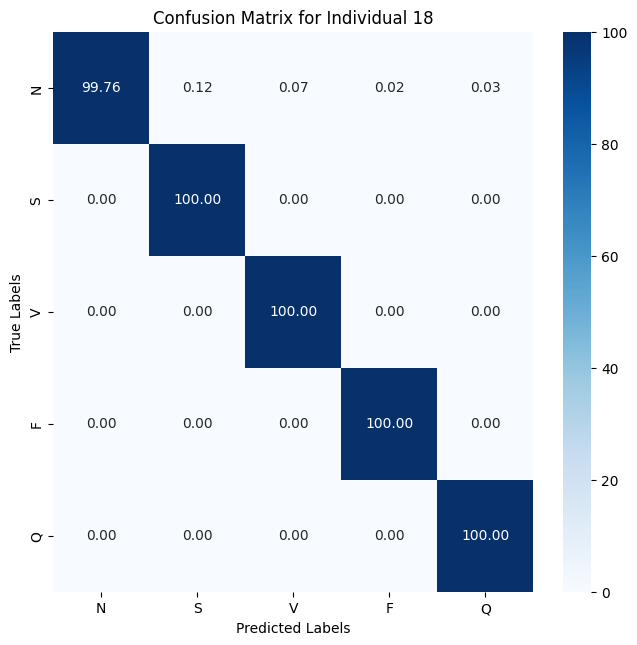

2024-04-16 05:58:17,210 - INFO - Calculating fitness for individual 19/30


X_params shape: (1, 2)
n_estimators: 1265 max_depth: 13


2024-04-16 05:58:50,421 - INFO - Fitness for individual 19: 0.9939696509912188


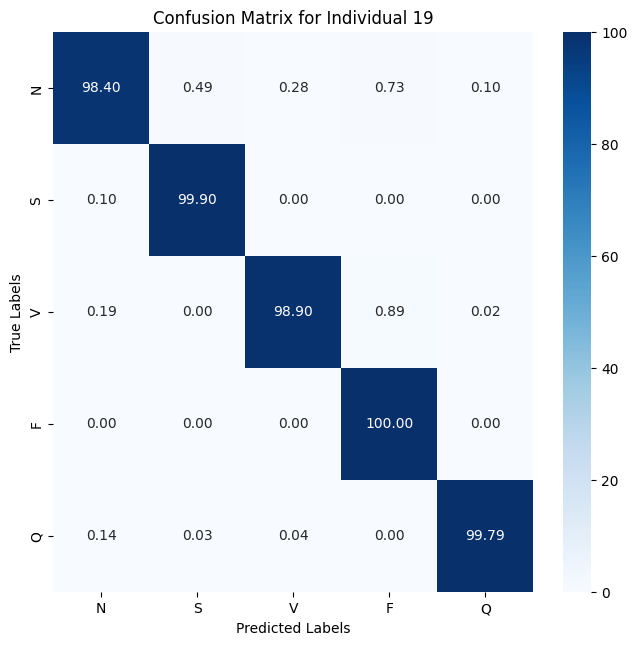

2024-04-16 05:58:50,839 - INFO - Calculating fitness for individual 20/30


X_params shape: (1, 2)
n_estimators: 559 max_depth: 39


2024-04-16 05:59:16,269 - INFO - Fitness for individual 20: 0.9989477324673095


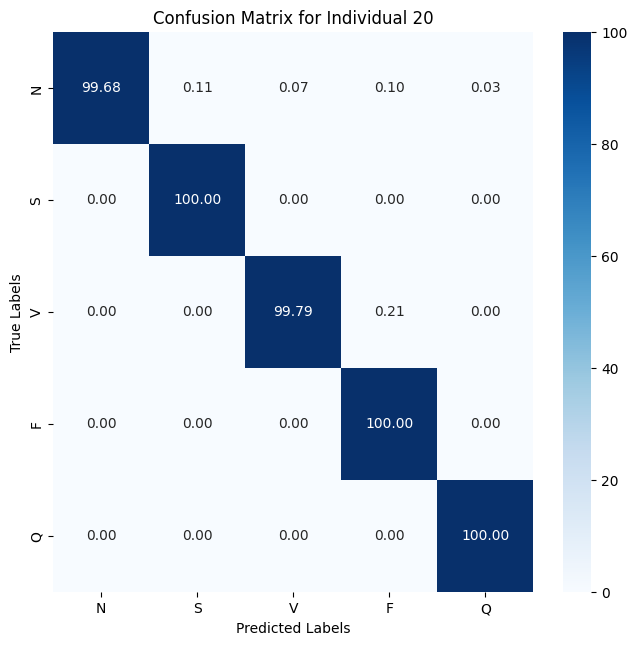

2024-04-16 05:59:16,634 - INFO - Calculating fitness for individual 21/30


X_params shape: (1, 2)
n_estimators: 1787 max_depth: 88


2024-04-16 06:00:55,271 - INFO - Fitness for individual 21: 0.999529802240354


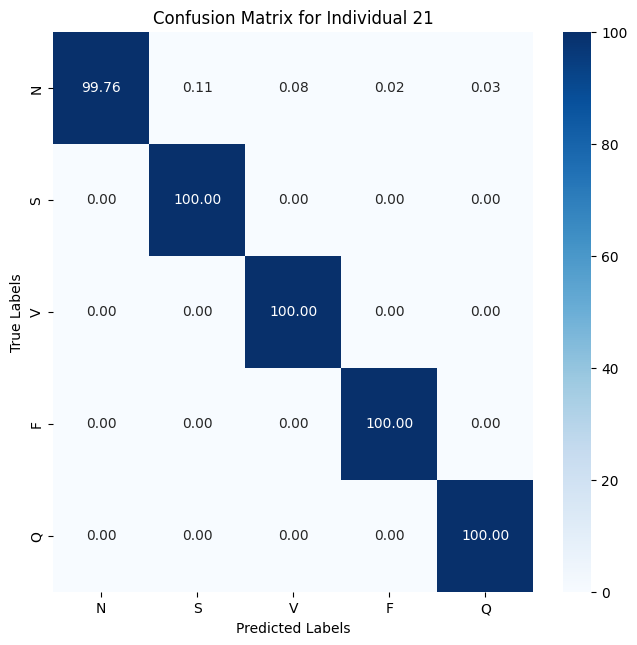

2024-04-16 06:00:55,648 - INFO - Calculating fitness for individual 22/30


X_params shape: (1, 2)
n_estimators: 57 max_depth: 79


2024-04-16 06:00:59,061 - INFO - Fitness for individual 22: 0.9995021435486102


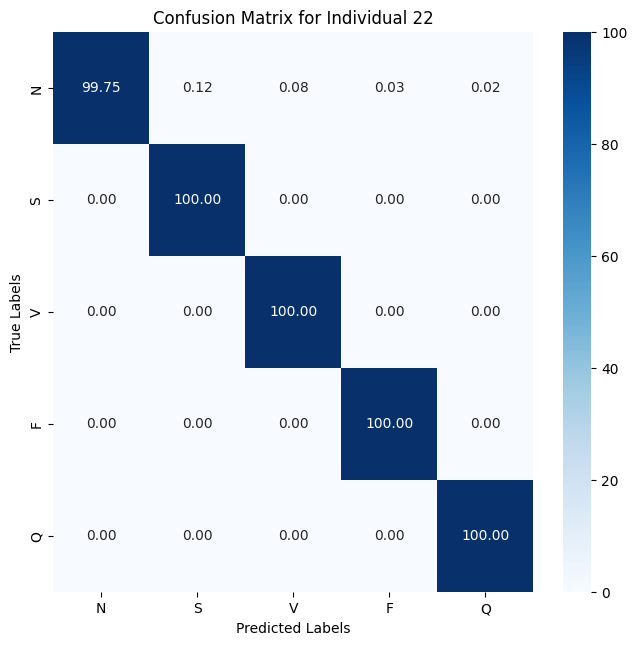

2024-04-16 06:00:59,457 - INFO - Calculating fitness for individual 23/30


X_params shape: (1, 2)
n_estimators: 778 max_depth: 20


2024-04-16 06:01:24,987 - INFO - Fitness for individual 23: 0.9974106542396995


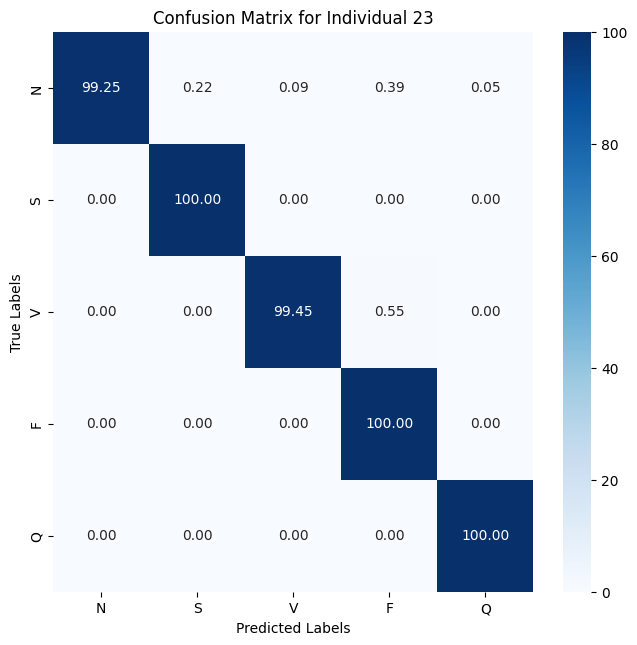

2024-04-16 06:01:25,397 - INFO - Calculating fitness for individual 24/30


X_params shape: (1, 2)
n_estimators: 991 max_depth: 12


2024-04-16 06:01:49,323 - INFO - Fitness for individual 24: 0.9898593368122759


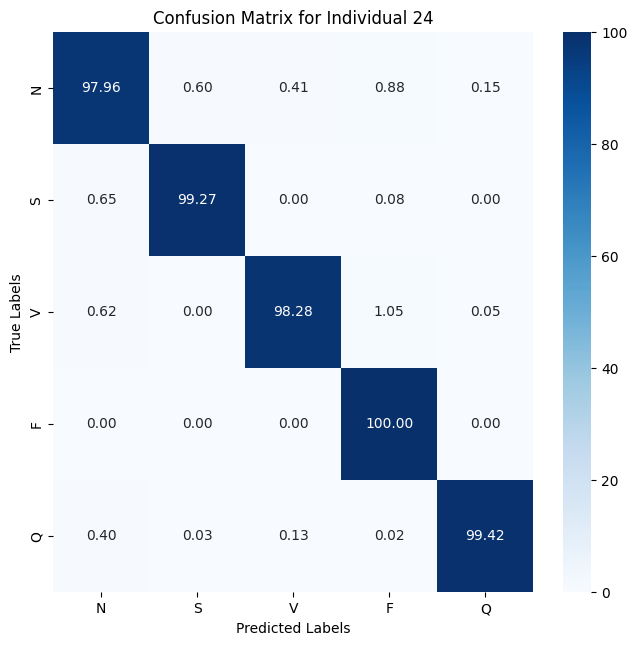

2024-04-16 06:01:49,702 - INFO - Calculating fitness for individual 25/30


X_params shape: (1, 2)
n_estimators: 411 max_depth: 102


2024-04-16 06:02:12,648 - INFO - Fitness for individual 25: 0.9995021435486102


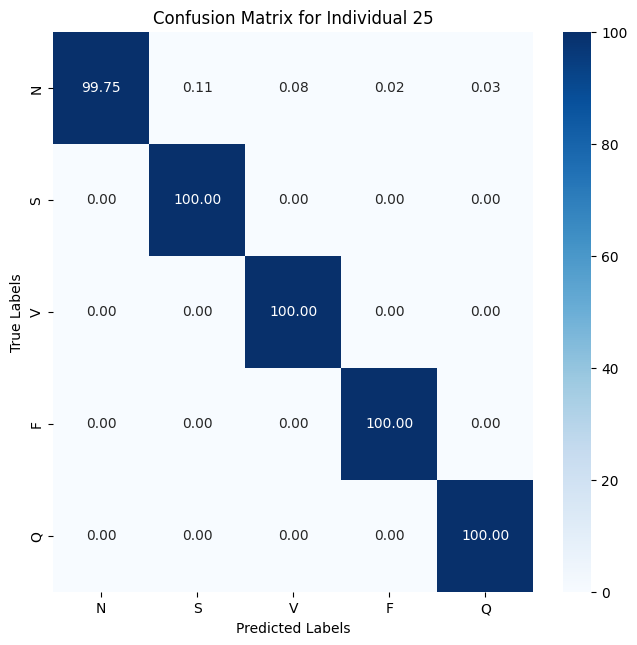

2024-04-16 06:02:13,279 - INFO - Calculating fitness for individual 26/30


X_params shape: (1, 2)
n_estimators: 635 max_depth: 73


2024-04-16 06:02:48,088 - INFO - Fitness for individual 26: 0.999515972894482


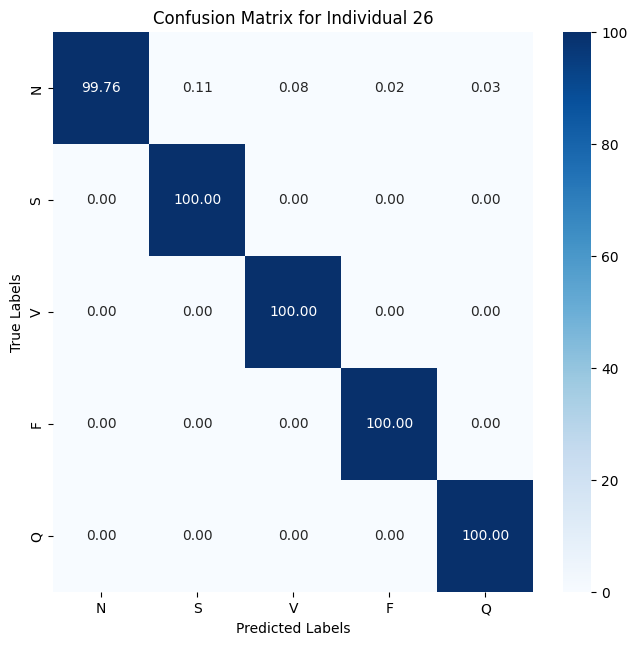

2024-04-16 06:02:48,468 - INFO - Calculating fitness for individual 27/30


X_params shape: (1, 2)
n_estimators: 501 max_depth: 60


2024-04-16 06:03:14,985 - INFO - Fitness for individual 27: 0.9995021435486102


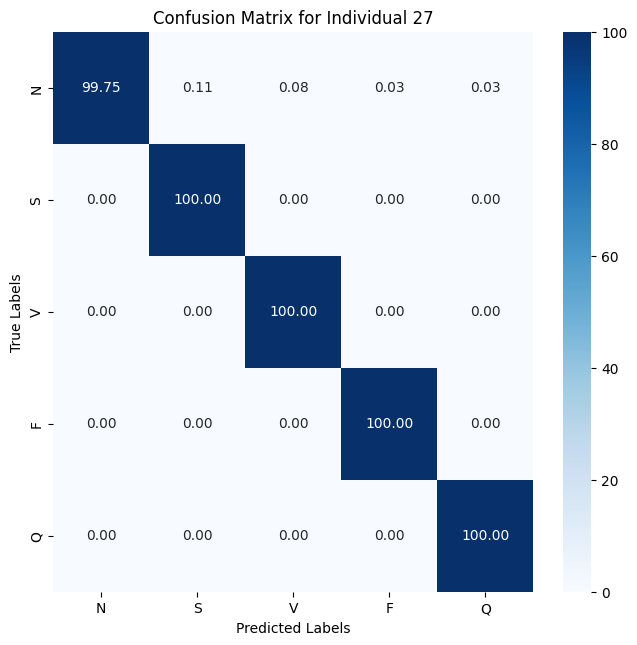

2024-04-16 06:03:15,357 - INFO - Calculating fitness for individual 28/30


X_params shape: (1, 2)
n_estimators: 879 max_depth: 60


2024-04-16 06:04:01,795 - INFO - Fitness for individual 28: 0.999529802240354


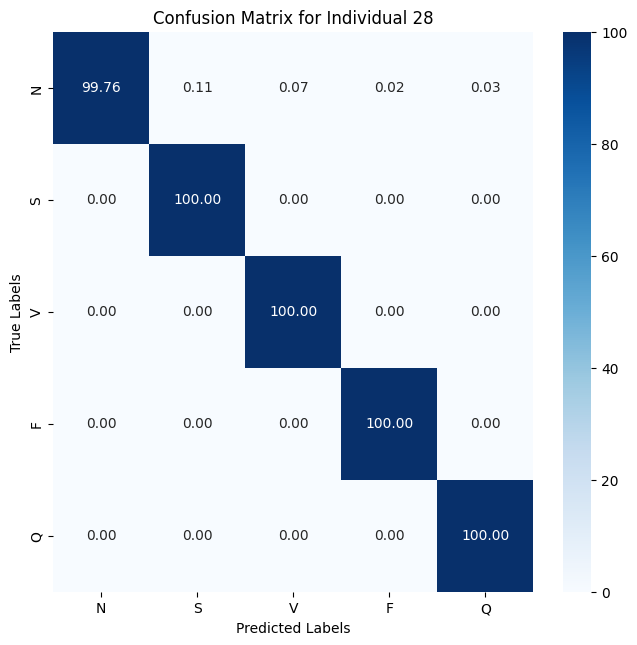

2024-04-16 06:04:02,165 - INFO - Calculating fitness for individual 29/30


X_params shape: (1, 2)
n_estimators: 1001 max_depth: 63


2024-04-16 06:04:56,131 - INFO - Fitness for individual 29: 0.999529802240354


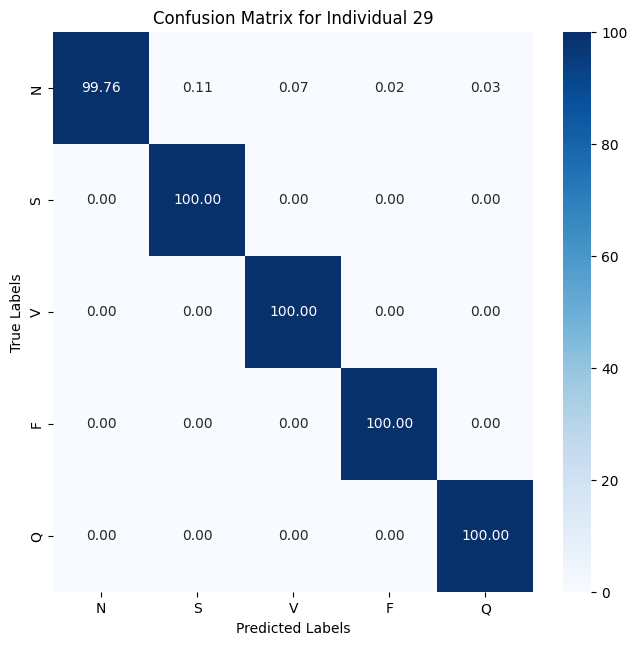

2024-04-16 06:04:56,503 - INFO - Calculating fitness for individual 30/30


X_params shape: (1, 2)
n_estimators: 1388 max_depth: 87


2024-04-16 06:06:12,992 - INFO - Fitness for individual 30: 0.999529802240354


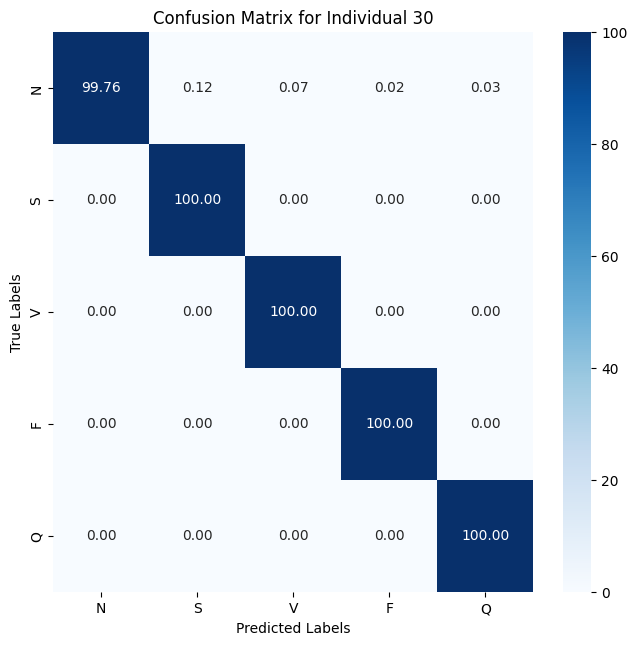

2024-04-16 06:06:13,370 - INFO - Calculating fitness for individual after 3 Phases 1/30


X_params shape: (1, 2)
n_estimators: 743 max_depth: 32


2024-04-16 06:06:44,442 - INFO - Fitness for individual 1: 0.9986012977142046


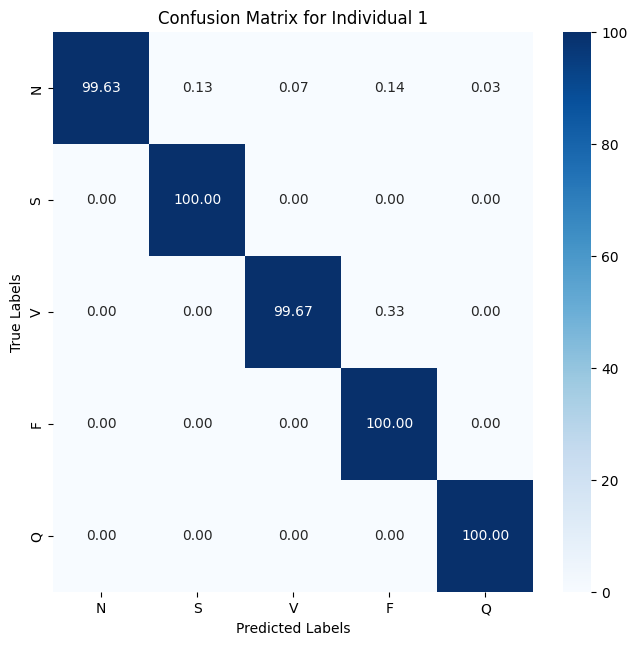

2024-04-16 06:06:44,841 - INFO - Calculating fitness for individual after 3 Phases 2/30


X_params shape: (1, 2)
n_estimators: 471 max_depth: 84


2024-04-16 06:07:10,883 - INFO - Fitness for individual 2: 0.999529802240354


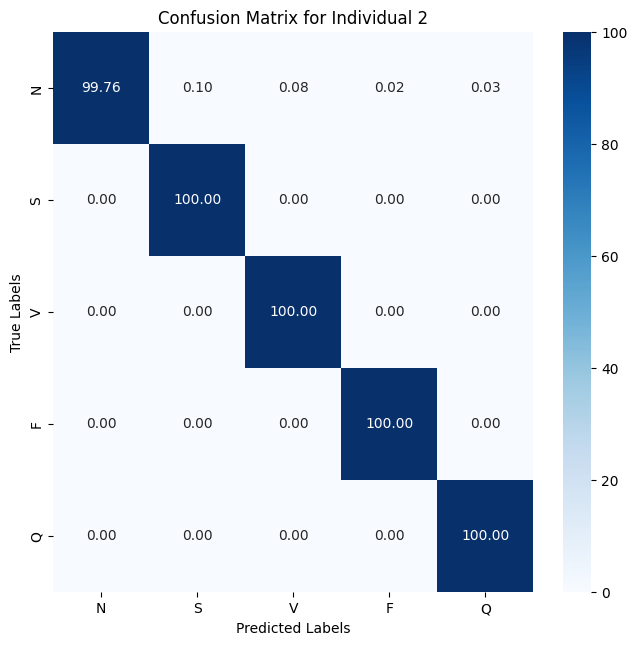

2024-04-16 06:07:11,251 - INFO - Calculating fitness for individual after 3 Phases 3/30


X_params shape: (1, 2)
n_estimators: 417 max_depth: 13


2024-04-16 06:07:22,024 - INFO - Fitness for individual 3: 0.9937065507829091


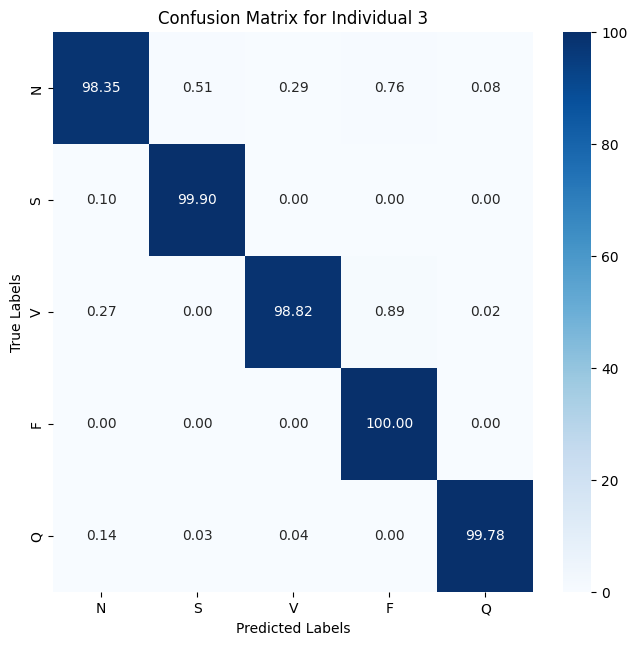

2024-04-16 06:07:22,399 - INFO - Calculating fitness for individual after 3 Phases 4/30


X_params shape: (1, 2)
n_estimators: 1564 max_depth: 78


2024-04-16 06:08:48,047 - INFO - Fitness for individual 4: 0.9995021435486102


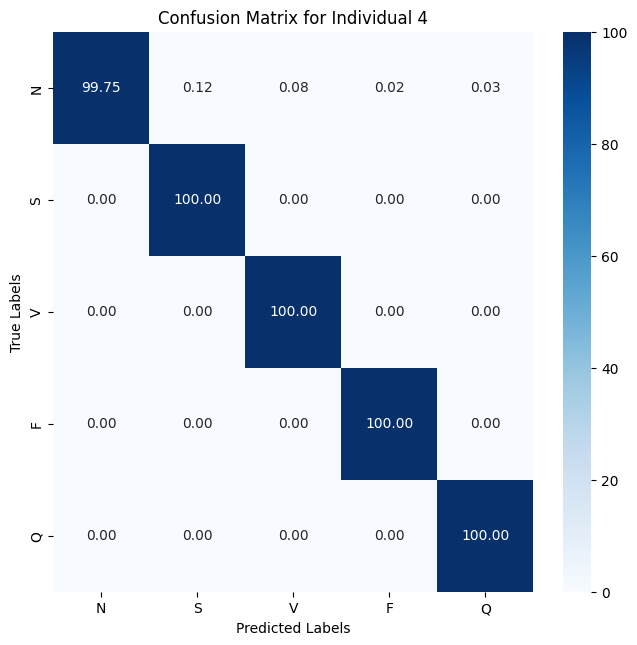

2024-04-16 06:08:48,418 - INFO - Calculating fitness for individual after 3 Phases 5/30


X_params shape: (1, 2)
n_estimators: 498 max_depth: 65


2024-04-16 06:09:15,390 - INFO - Fitness for individual 5: 0.999529802240354


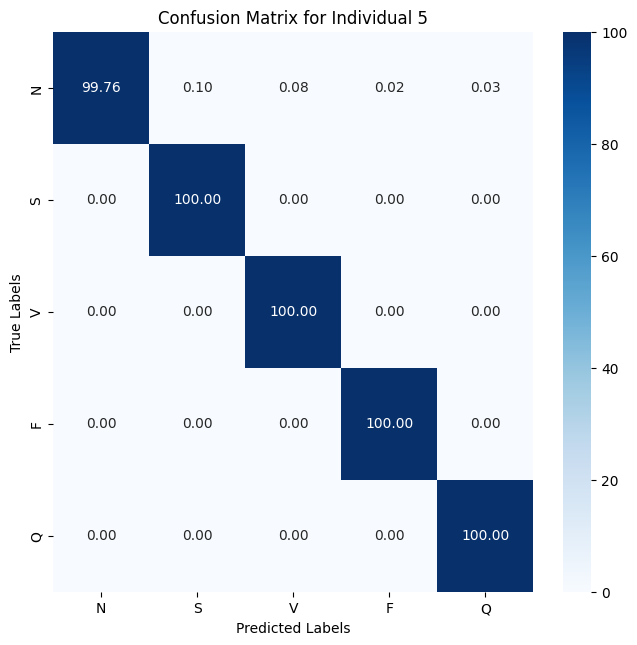

2024-04-16 06:09:15,759 - INFO - Calculating fitness for individual after 3 Phases 6/30


X_params shape: (1, 2)
n_estimators: 1019 max_depth: 10


2024-04-16 06:09:37,881 - INFO - Fitness for individual 6: 0.9694571873022


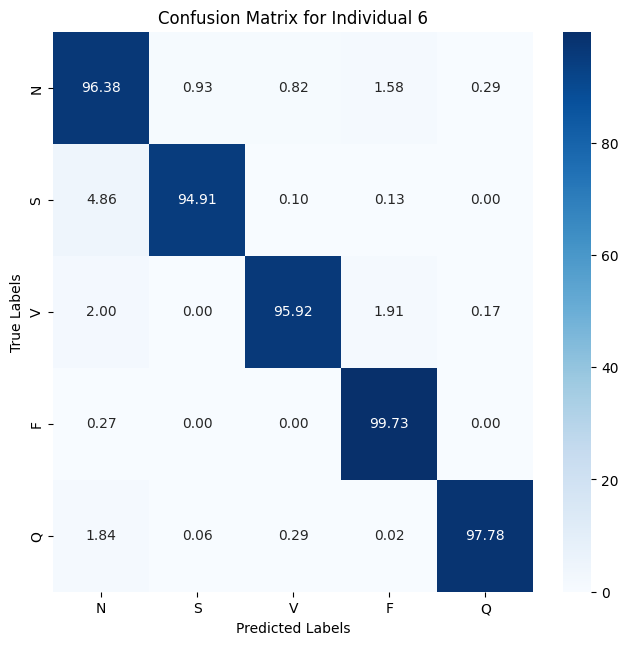

2024-04-16 06:09:38,250 - INFO - Calculating fitness for individual after 3 Phases 7/30


X_params shape: (1, 2)
n_estimators: 340 max_depth: 93


2024-04-16 06:09:57,617 - INFO - Fitness for individual 7: 0.9994744848568663


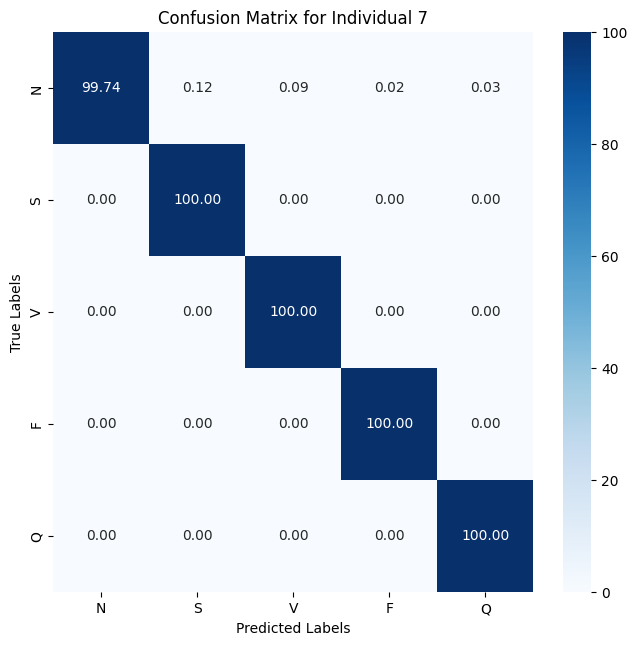

2024-04-16 06:09:58,048 - INFO - Calculating fitness for individual after 3 Phases 8/30


X_params shape: (1, 2)
n_estimators: 336 max_depth: 66


2024-04-16 06:10:16,506 - INFO - Fitness for individual 8: 0.9994744848568663


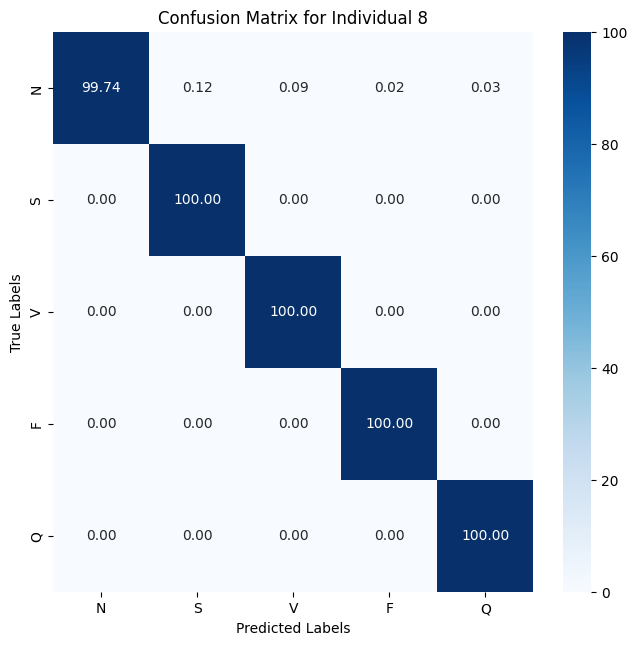

2024-04-16 06:10:16,883 - INFO - Calculating fitness for individual after 3 Phases 9/30


X_params shape: (1, 2)
n_estimators: 569 max_depth: 35


2024-04-16 06:10:41,858 - INFO - Fitness for individual 9: 0.9986705681682064


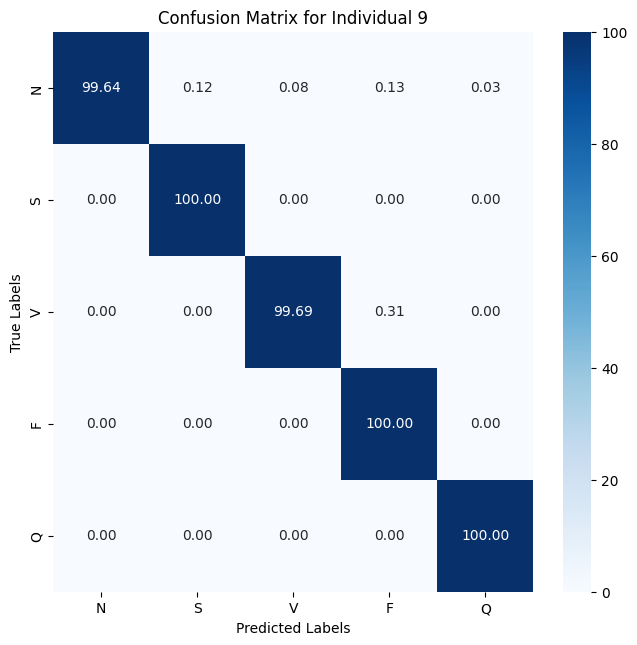

2024-04-16 06:10:42,227 - INFO - Calculating fitness for individual after 3 Phases 10/30


X_params shape: (1, 2)
n_estimators: 884 max_depth: 10


2024-04-16 06:11:01,091 - INFO - Fitness for individual 10: 0.9694450722406286


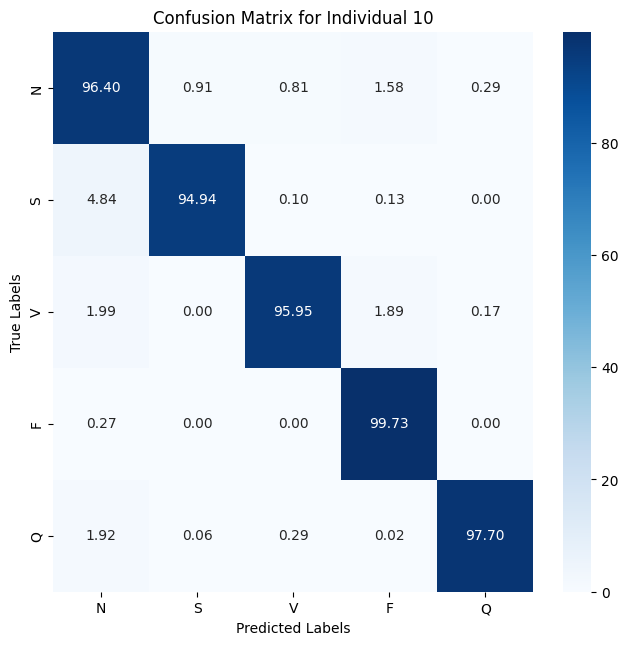

2024-04-16 06:11:01,498 - INFO - Calculating fitness for individual after 3 Phases 11/30


X_params shape: (1, 2)
n_estimators: 892 max_depth: 10


2024-04-16 06:11:20,500 - INFO - Fitness for individual 11: 0.9693623060478055


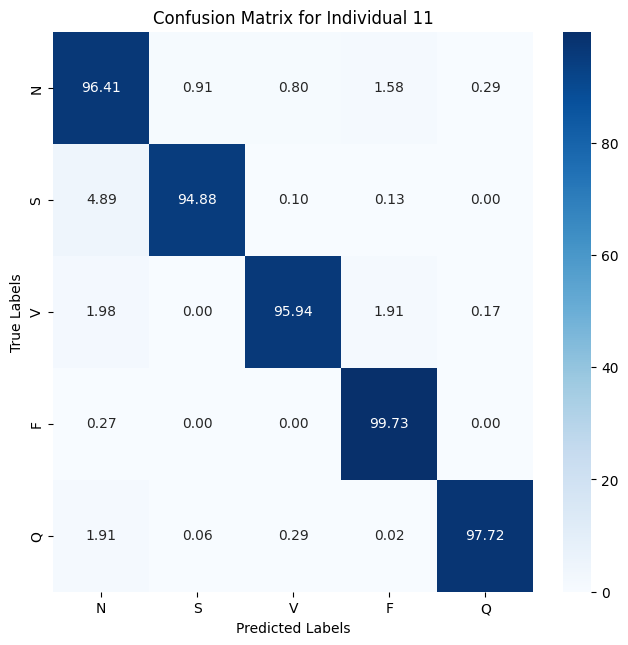

2024-04-16 06:11:21,135 - INFO - Calculating fitness for individual after 3 Phases 12/30


X_params shape: (1, 2)
n_estimators: 1586 max_depth: 57


2024-04-16 06:12:44,154 - INFO - Fitness for individual 12: 0.9994883142027382


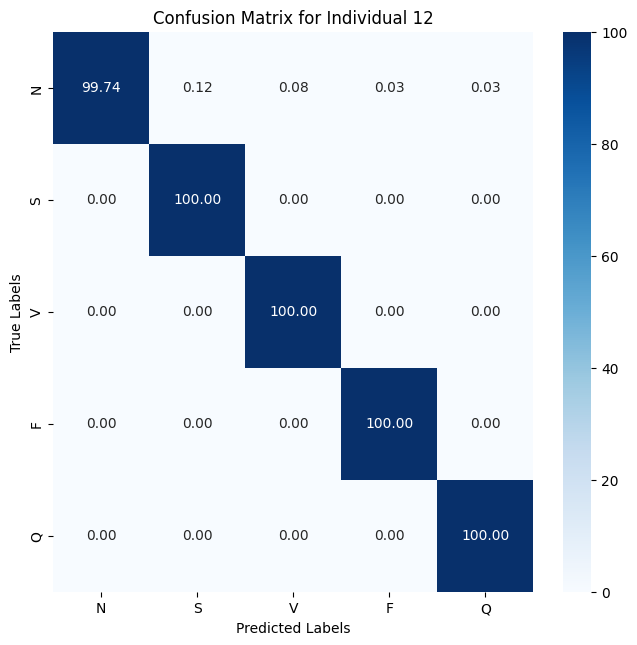

2024-04-16 06:12:44,528 - INFO - Calculating fitness for individual after 3 Phases 13/30


X_params shape: (1, 2)
n_estimators: 691 max_depth: 71


2024-04-16 06:13:22,804 - INFO - Fitness for individual 13: 0.999529802240354


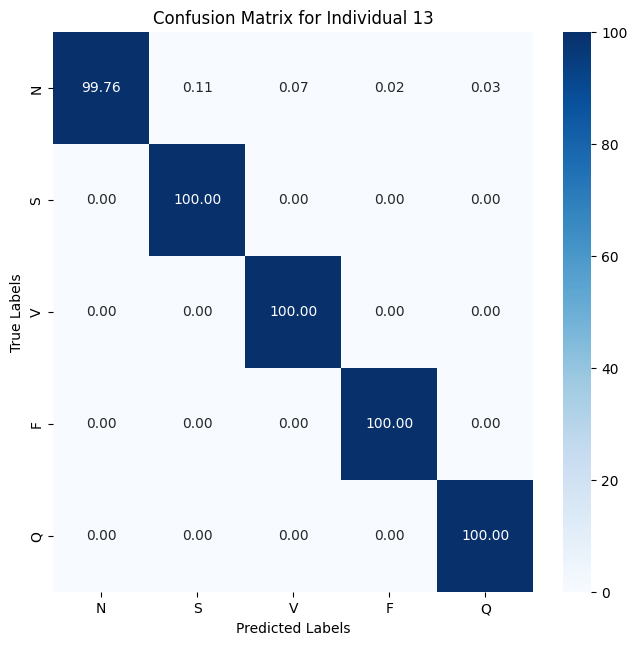

2024-04-16 06:13:23,172 - INFO - Calculating fitness for individual after 3 Phases 14/30


X_params shape: (1, 2)
n_estimators: 1844 max_depth: 57


2024-04-16 06:14:59,066 - INFO - Fitness for individual 14: 0.999529802240354


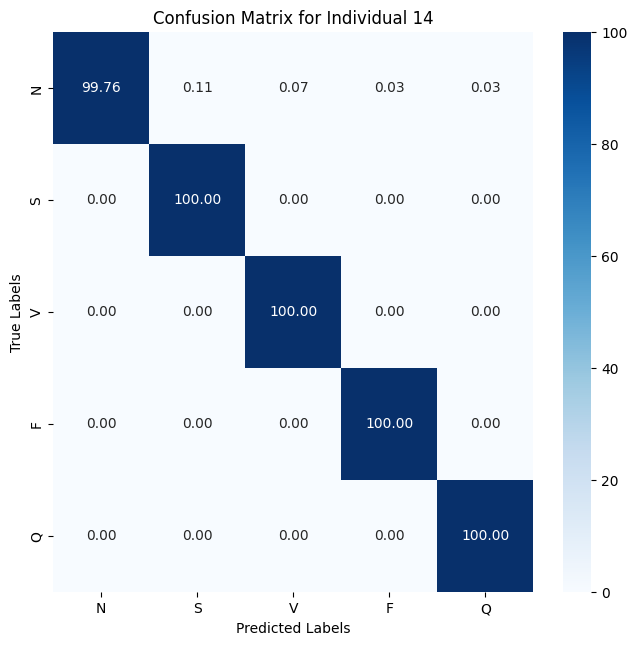

2024-04-16 06:14:59,486 - INFO - Calculating fitness for individual after 3 Phases 15/30


X_params shape: (1, 2)
n_estimators: 10 max_depth: 68


2024-04-16 06:15:00,288 - INFO - Fitness for individual 15: 0.9992255566311712


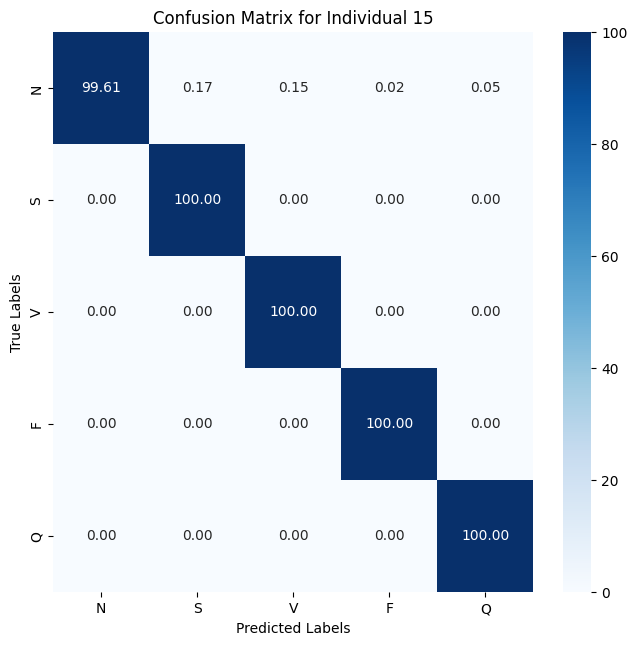

2024-04-16 06:15:00,652 - INFO - Calculating fitness for individual after 3 Phases 16/30


X_params shape: (1, 2)
n_estimators: 528 max_depth: 71


2024-04-16 06:15:29,955 - INFO - Fitness for individual 16: 0.999529802240354


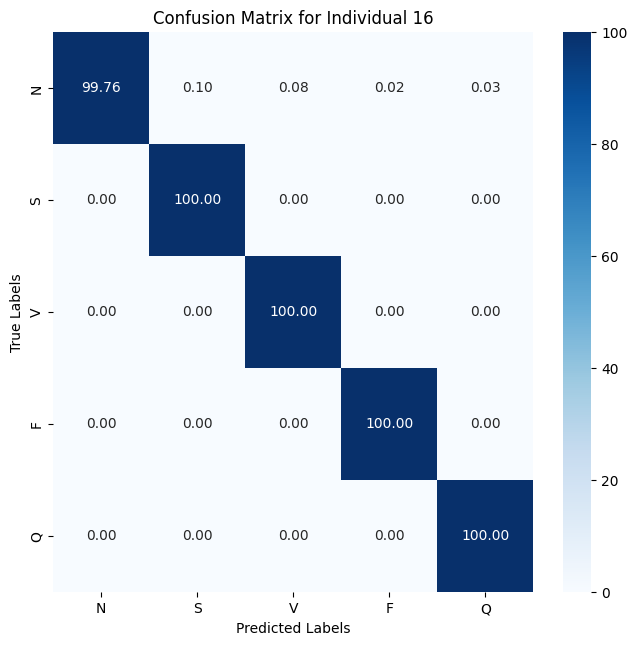

2024-04-16 06:15:30,339 - INFO - Calculating fitness for individual after 3 Phases 17/30


X_params shape: (1, 2)
n_estimators: 10 max_depth: 22


2024-04-16 06:15:30,911 - INFO - Fitness for individual 17: 0.9973138075770486


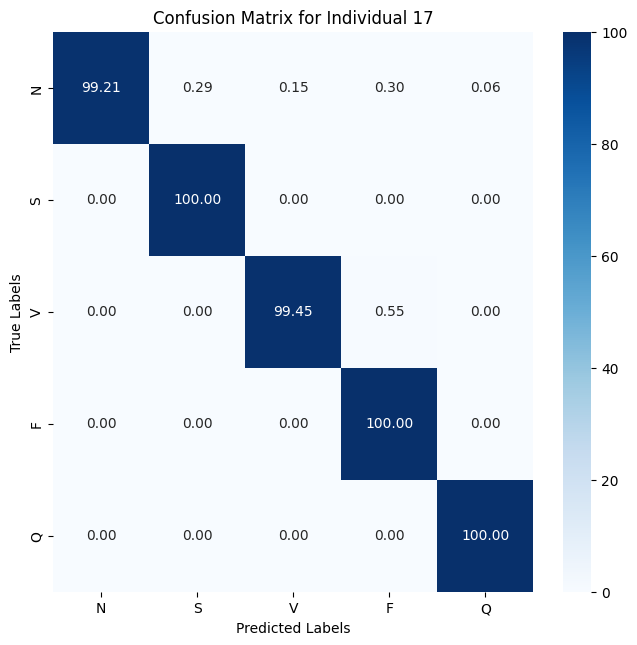

2024-04-16 06:15:31,283 - INFO - Calculating fitness for individual after 3 Phases 18/30


X_params shape: (1, 2)
n_estimators: 1419 max_depth: 70


2024-04-16 06:16:49,094 - INFO - Fitness for individual 18: 0.999515972894482


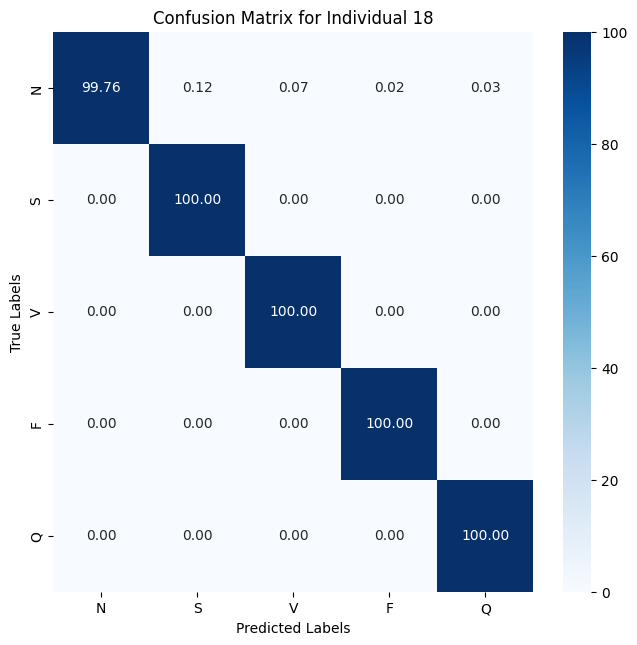

2024-04-16 06:16:49,459 - INFO - Calculating fitness for individual after 3 Phases 19/30


X_params shape: (1, 2)
n_estimators: 10 max_depth: 10


2024-04-16 06:16:49,981 - INFO - Fitness for individual 19: 0.9633581432234685


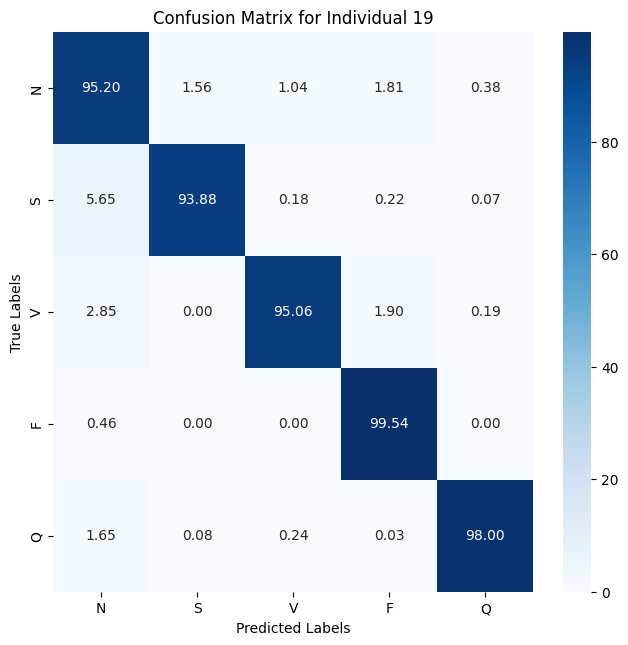

2024-04-16 06:16:50,348 - INFO - Calculating fitness for individual after 3 Phases 20/30


X_params shape: (1, 2)
n_estimators: 551 max_depth: 43


2024-04-16 06:17:16,314 - INFO - Fitness for individual 20: 0.9991279676206665


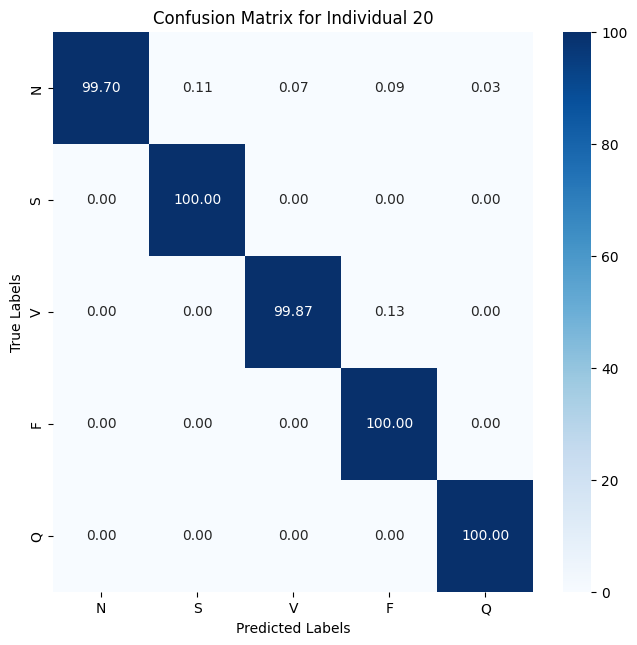

2024-04-16 06:17:16,686 - INFO - Calculating fitness for individual after 3 Phases 21/30


X_params shape: (1, 2)
n_estimators: 1404 max_depth: 88


2024-04-16 06:18:34,150 - INFO - Fitness for individual 21: 0.999529802240354


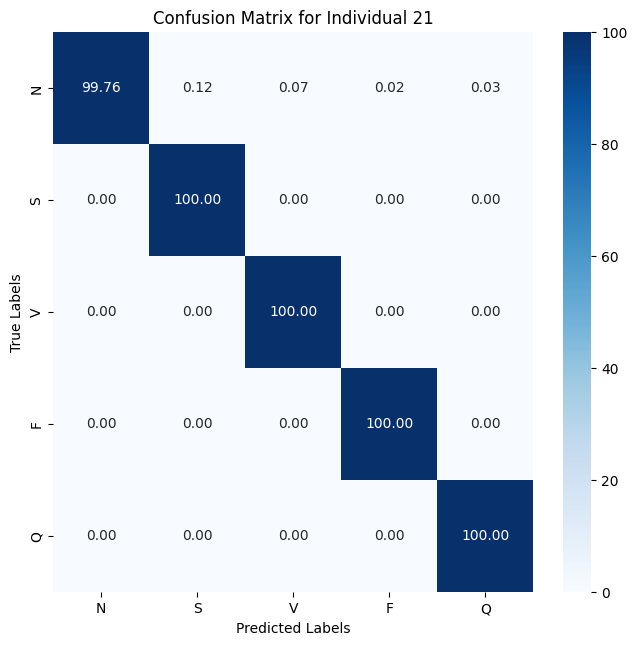

2024-04-16 06:18:34,525 - INFO - Calculating fitness for individual after 3 Phases 22/30


X_params shape: (1, 2)
n_estimators: 10 max_depth: 72


2024-04-16 06:18:35,505 - INFO - Fitness for individual 22: 0.9992255566311712


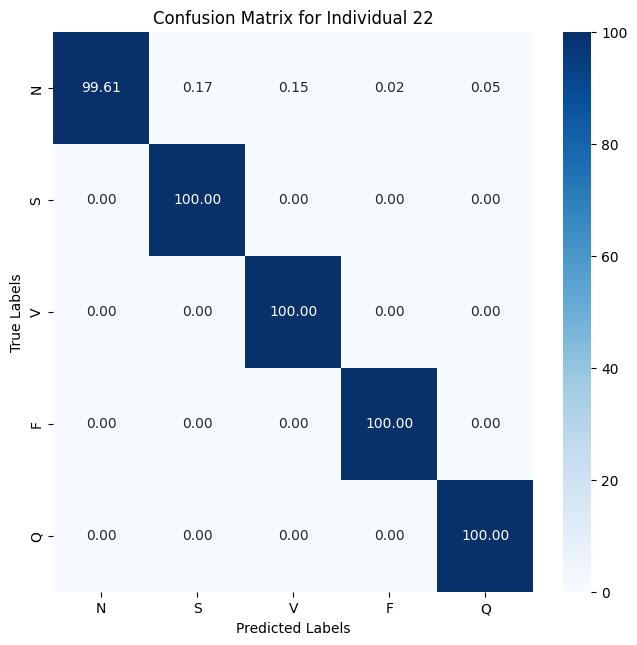

2024-04-16 06:18:35,870 - INFO - Calculating fitness for individual after 3 Phases 23/30


X_params shape: (1, 2)
n_estimators: 172 max_depth: 34


2024-04-16 06:18:43,457 - INFO - Fitness for individual 23: 0.9985736390224605


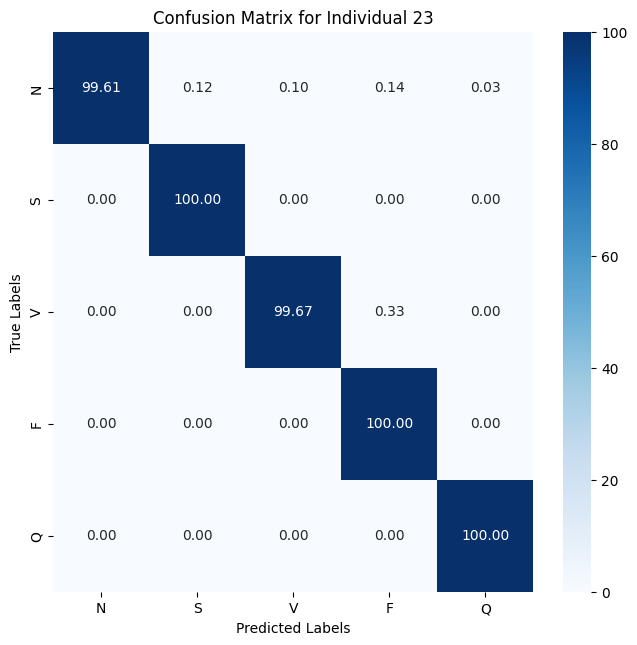

2024-04-16 06:18:43,829 - INFO - Calculating fitness for individual after 3 Phases 24/30


X_params shape: (1, 2)
n_estimators: 934 max_depth: 38


2024-04-16 06:19:25,891 - INFO - Fitness for individual 24: 0.998864591425888


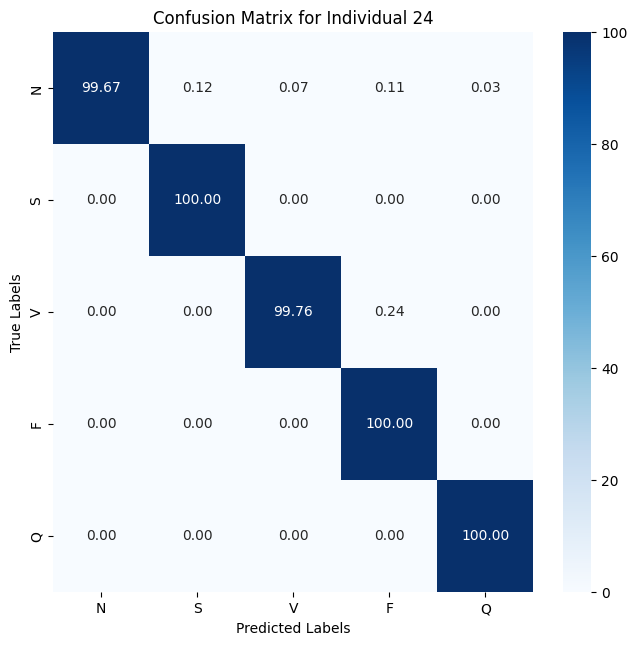

2024-04-16 06:19:26,256 - INFO - Calculating fitness for individual after 3 Phases 25/30


X_params shape: (1, 2)
n_estimators: 385 max_depth: 105


2024-04-16 06:19:47,654 - INFO - Fitness for individual 25: 0.9994606555109943


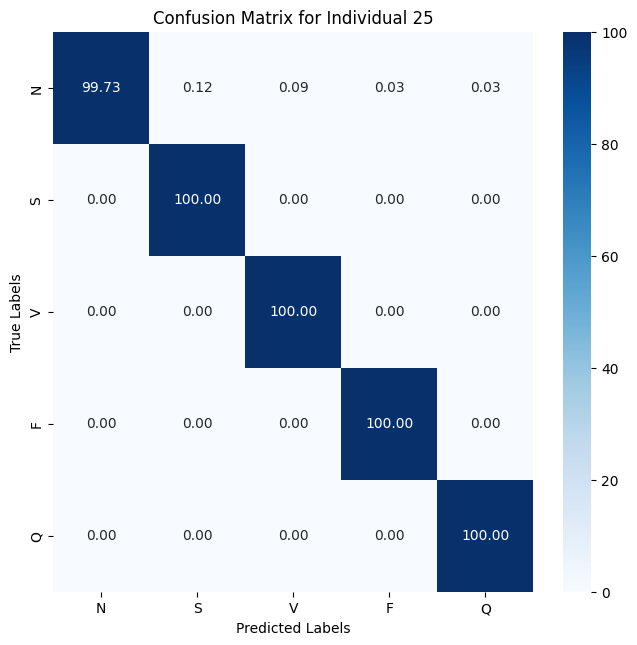

2024-04-16 06:19:48,044 - INFO - Calculating fitness for individual after 3 Phases 26/30


X_params shape: (1, 2)
n_estimators: 99 max_depth: 73


2024-04-16 06:19:54,113 - INFO - Fitness for individual 26: 0.9994744848568663


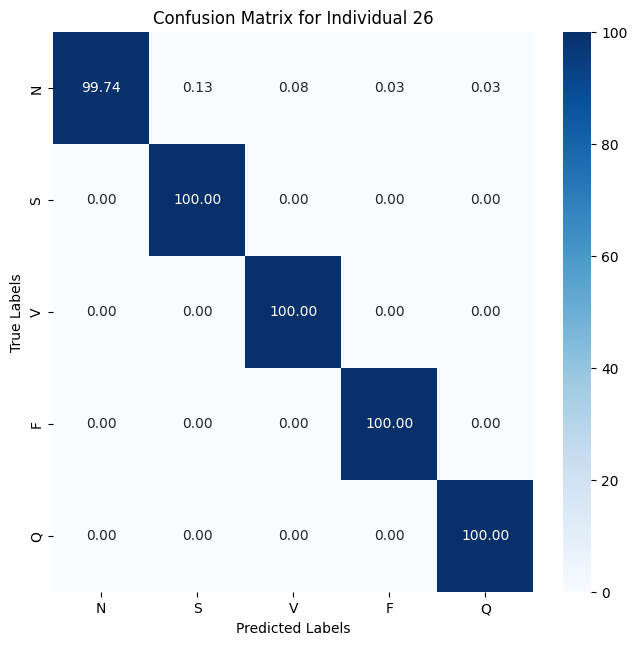

2024-04-16 06:19:54,740 - INFO - Calculating fitness for individual after 3 Phases 27/30


X_params shape: (1, 2)
n_estimators: 471 max_depth: 58


2024-04-16 06:20:19,698 - INFO - Fitness for individual 27: 0.999515972894482


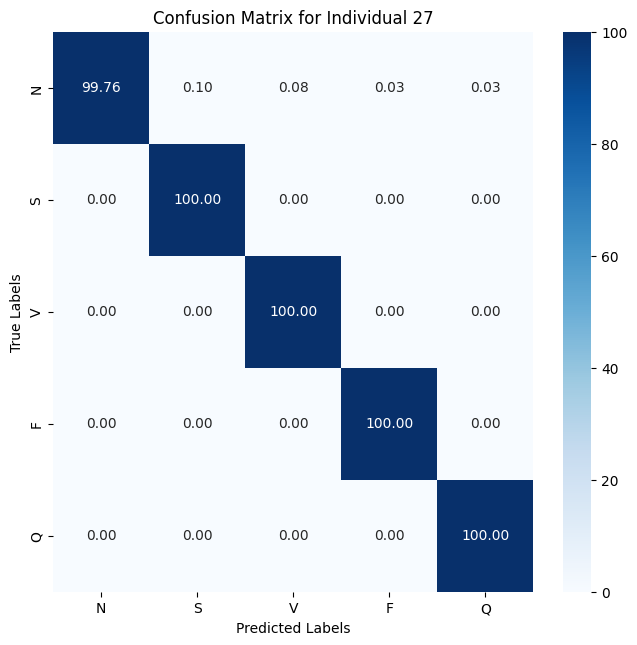

2024-04-16 06:20:20,071 - INFO - Calculating fitness for individual after 3 Phases 28/30


X_params shape: (1, 2)
n_estimators: 572 max_depth: 32


2024-04-16 06:20:44,152 - INFO - Fitness for individual 28: 0.9985736390224605


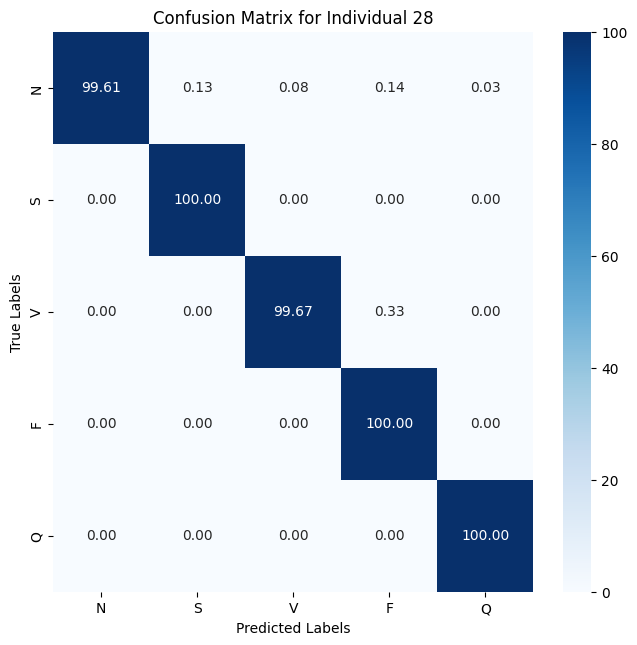

2024-04-16 06:20:44,516 - INFO - Calculating fitness for individual after 3 Phases 29/30


X_params shape: (1, 2)
n_estimators: 641 max_depth: 31


2024-04-16 06:21:11,218 - INFO - Fitness for individual 29: 0.9985736390224605


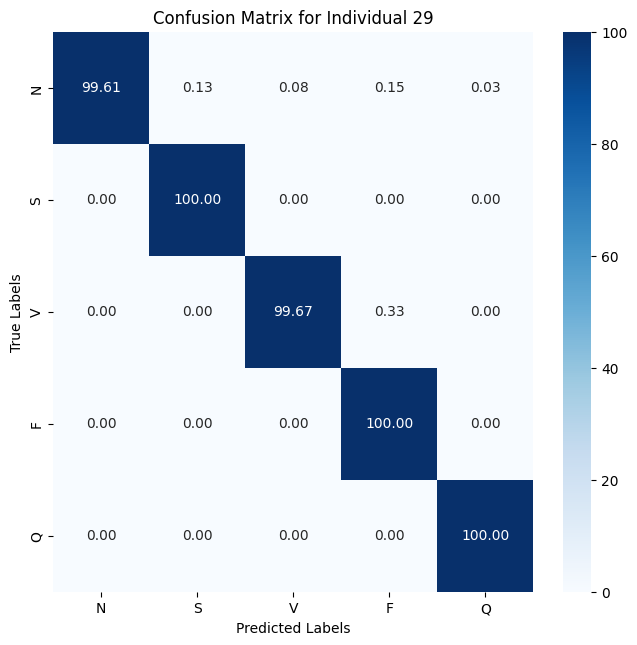

2024-04-16 06:21:11,669 - INFO - Calculating fitness for individual after 3 Phases 30/30


X_params shape: (1, 2)
n_estimators: 820 max_depth: 89


2024-04-16 06:21:57,314 - INFO - Fitness for individual 30: 0.999529802240354


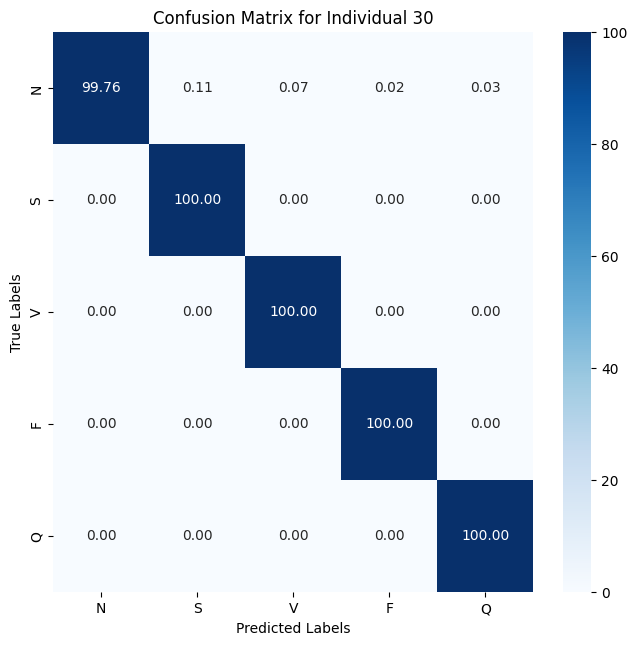

2024-04-16 06:21:57,720 - INFO - Iteration: 1/20, Best Fitness: 0.9995574609320979, Average Fitness: 0.9948231550579043
2024-04-16 06:21:57,721 - INFO - Fitness threshold reached: 0.9995574609320979 at iteration 1. Terminating...
2024-04-16 06:21:57,723 - INFO - Model saved to best_model_mpa_RF_mit.pkl with fitness 0.9995574609320979 at iteration 1
2024-04-16 06:21:57,724 - INFO - Finished MPA_RF optimization for MIT dataset. Total duration: 39.45 minutes.
2024-04-16 06:21:57,725 - INFO - Top predator position (rounded to integers): [527, 68]
2024-04-16 06:21:57,726 - INFO - Top predator fitness: 0.9995574609320979


Top predator position (rounded to integers): [527, 68]
Top predator fitness: 0.9995574609320979


In [7]:
import time

def run_mpa_for_all_labels(X_train, X_val, y_train, y_val, search_agents_no, Max_iter, lb, ub, dim, rf_accuracy_fitness, fitness_threshold=0.95):
    """
    Runs MPA optimization for all labels and plots the convergence curve for each label.

    Parameters:
    - X_train, X_val, y_train, y_val: Training and validation sets.
    - search_agents_no: Number of search agents.
    - Max_iter: Maximum number of iterations.
    - lb, ub: Lower and upper bounds for optimization parameters.
    - dim: Number of dimensions/hyperparameters.
    - rf_accuracy_fitness: Fitness function for the Random Forest model.
    - fitness_threshold: Threshold for stopping the optimization.
    """
    overall_start_time = time.time()

    # Example usage with correctly structured return values for MPA
    results = {}  # Assuming MPA should populate this dictionary
    
    # Example call to MPA for one label (extend as needed for multiple labels)
    top_predator_pos, top_predator_fit = MPA(
        search_agents_no, Max_iter, lb, ub, dim, 
        X_train, y_train, X_val, y_val, 
        rf_accuracy_fitness, fitness_threshold
    )
    
    # Rounding top predator position to nearest integers for logging and usage
    rounded_top_predator_pos = [round(pos) for pos in top_predator_pos]

    # Populate the results dictionary with mock label data (extend as needed)
    results['MockLabel'] = {
        'Top_predator_pos': rounded_top_predator_pos,
        'Top_predator_fitness': top_predator_fit
    }

    overall_end_time = time.time()
    total_duration_minutes = (overall_end_time - overall_start_time) / 60

    # Get the top predator position and fitness from the 'results' dictionary for the mock label
    top_predator_pos = results['MockLabel']['Top_predator_pos']
    top_predator_fit = results['MockLabel']['Top_predator_fitness']
    
    # Log the top predator fitness and position
    logging.info(f"Finished MPA_RF optimization for MIT dataset. Total duration: {total_duration_minutes:.2f} minutes.")
    logging.info(f"Top predator position (rounded to integers): {top_predator_pos}")
    logging.info(f"Top predator fitness: {top_predator_fit}")
    
    # Optionally, print them out to the console as well
    print(f"Top predator position (rounded to integers): {top_predator_pos}")
    print(f"Top predator fitness: {top_predator_fit}")


run_mpa_for_all_labels(X_train, X_val, y_train, y_val, search_agents_no, Max_iter, lb, ub, dim, rf_accuracy_fitness, fitness_threshold=0.95)


### Evaluate on Test dataset

In [8]:
import cudf
# Example loading test data (adjust path and processing as needed)
test_data = cudf.read_csv('/home/jupyter-yangiev/MPA_int_ML/mitbih_test_new.csv')

columns = test_data.columns.tolist()
features = [col for col in columns if col != '187']
labels = '187'

X_test = test_data[features].astype('float32')
y_test = test_data['187'].astype('int32')  # Adjust label column as per your dataset


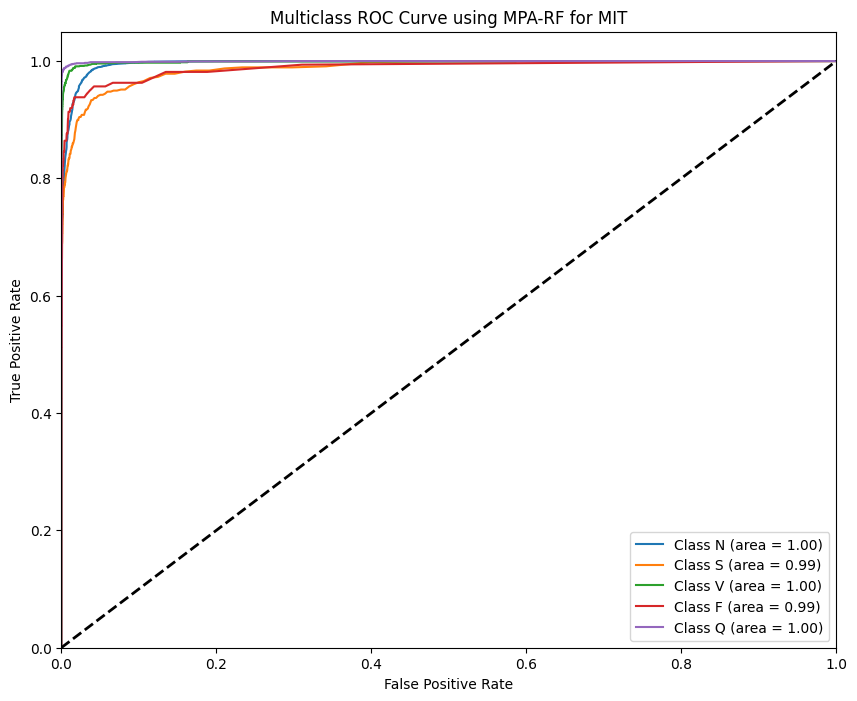

              precision    recall  f1-score   support

           N       0.84      0.65      0.74       162
           S       0.98      1.00      0.99     18118
           V       1.00      0.96      0.98      1608
           F       0.95      0.68      0.79       556
           Q       0.97      0.92      0.95      1448

    accuracy                           0.98     21892
   macro avg       0.95      0.84      0.89     21892
weighted avg       0.98      0.98      0.98     21892

roc_auc_ovr score: 0.9940325531875793
roc_auc_ovo score: 0.9940325531875793


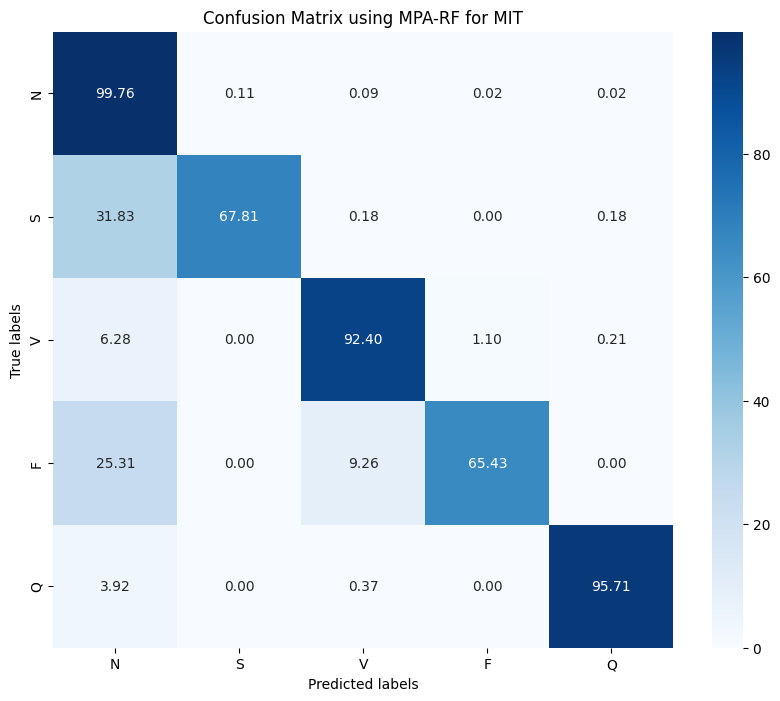

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cuml.ensemble import RandomForestClassifier as cumlRF
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
import seaborn as sns
from cuml import set_global_output_type
import numpy as np

# Set global output type to cupy for cuML compatibility with cuPy
set_global_output_type('cupy')

# Load the best model saved from MPA
with open('best_model_mpa_RF_mit.pkl', 'rb') as f:
    model = pickle.load(f)
    
model.fit(X_train, y_train)

# Predict probabilities for ROC AUC  
y_prob = model.predict_proba(X_test).get()

# Predict class labels for confusion matrix and other metrics  
y_pred = model.predict(X_test).get()

# Convert y_test to NumPy
y_test_np = y_test.to_numpy()

# Custom label mapping
label_mapping = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

# Apply the mapping to your test labels and predictions
y_test_mapped = np.vectorize(label_mapping.get)(y_test_np)
y_pred_mapped = np.vectorize(label_mapping.get)(y_pred)

# Binarize the output for multiclass ROC AUC
y_test_bin = label_binarize(y_test_mapped, classes=list(label_mapping.values()))
n_classes = y_test_bin.shape[1]

# Calculate performance metrics
roc_auc_ovr = roc_auc_score(y_test_bin, y_prob, multi_class='ovr', average='macro')
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
precision = precision_score(y_test_mapped, y_pred_mapped, average='macro')
recall = recall_score(y_test_mapped, y_pred_mapped, average='macro')
f1 = f1_score(y_test_mapped, y_pred_mapped, average='macro')
accuracy = accuracy_score(y_test_mapped, y_pred_mapped)

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i, label in enumerate(label_mapping.values()):
    fpr[label], tpr[label], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[label] = auc(fpr[label], tpr[label])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for label in label_mapping.values():
    plt.plot(fpr[label], tpr[label], label=f'Class {label} (area = {roc_auc[label]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve using MPA-RF for MIT')
plt.legend(loc="lower right")
# Save the figure
plt.savefig('roc_curve_mpa_RF_mit.png', format='png', dpi=300)  # Save as high-res PNG
plt.show()


# Display classification report
print(classification_report(y_test_mapped, y_pred_mapped, target_names=list(label_mapping.values())))
print(f"roc_auc_ovr score: {roc_auc_ovr}")
print(f"roc_auc_ovo score: {roc_auc_ovo}")

# Assuming y_test_mapped and y_pred_mapped are already defined
cm = confusion_matrix(y_test_mapped, y_pred_mapped, labels=list(label_mapping.values()))

# Calculate the percentage for each cell in the confusion matrix
cm_percent = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Custom labels for the axes
labels = ['N', 'S', 'V', 'F', 'Q']

# Plotting using seaborn for more customization like annotations
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", cbar=True, 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix using MPA-RF for MIT')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('confusion_matrix_mpa_RF_mit.png', format='png', dpi=300)  # Save as high-res PNG
plt.show()
